**Описание проекта**

Мы работаем в IT-компании, которая выполняет на заказ проекты по машинному обучению. К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих бурёнок!

Поэтому он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нам нужно создать две прогнозные модели для отбора бурёнок в поголовье:

1.	Первая будет прогнозировать возможный удой у коровы (целевой признак Удой);
2.	Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:

•	Средний удой за год — не менее 6000 килограммов,

•	Молоко должно быть вкусным.


**Описание данных**

•	ЭКЕ (Энергетическая кормовая единица) `'efu'` — измерение питательности корма коровы;

•	Сырой протеин `'raw_protein'` — содержание сырого протеина в корме, в граммах;

•	СПО (Сахаро-протеиновое соотношение) `'sugar_protein_ratio'` — отношение сахара к протеину в корме коровы;

•	Тип пастбища `'pasture_type'` — ландшафт лугов, на которых паслась корова;

•	`'id'` — номер коровы;

•	Порода `'breed'` — порода коровы;

•	Возраст `'age'` — бинарный признак (менее 2 лет, более 2 лет);

•	порода папы быка `'dad_breed'` — порода папы коровы;

•	Имя Папы `'dad_name'` — имя папы-быка

•	Жирность `'fat_%'` — содержание жиров в молоке, в процентах;

•	Белок `'protein_%'` — содержание белков в молоке, в процентах;

•	Вкус молока `'taste_milk'` — оценка вкуса по личным критериям фермера;

•	Удой `'milk_yield'` — масса молока, которую корова даёт в год, в килограммах.

Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент. Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера. Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Параметры корма `ЭКЕ`, `Сырой протеин, г` и `СПО` отсутствуют для коров, которых фермер хочет изучить перед покупкой. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.

## Загрузка данных

In [1]:
# выполним необходимые инсталяции
!pip install seaborn -q --upgrade
!pip install pandas -q --upgrade
!pip install scikit-learn -q --upgrade
!pip install numba==0.60.0 -q
!pip install scipy==1.13.0 -q
!pip install numpy==1.26.4 -q

In [2]:
# выполним необходимые импорты
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import math
import os

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
# зафиксируем константу
RANDOM_STATE = 42

In [4]:
# выгрузим данные из 3-х таблиц с разделетелем ';' и сохраним в датафреймы
path_1 = 'https://code.s3.yandex.net/datasets/ferma_main.csv'
path_2 = '/datasets/ferma_main.csv'
if os.path.exists(path_1):
    data_ferma = pd.read_csv(path_1, sep = ';')
elif os.path.exists(path_2):
    data_ferma = pd.read_csv(path_2, sep = ';')
else:
    print('Something is wrong')

path_1 = 'https://code.s3.yandex.net/datasets/ferma_dad.csv'
path_2 = '/datasets/ferma_dad.csv'
if os.path.exists(path_1):
    ferma_dad = pd.read_csv(path_1, sep = ';')
elif os.path.exists(path_2):
    ferma_dad = pd.read_csv(path_2, sep = ';')
else:
    print('Something is wrong')

path_1 = 'https://code.s3.yandex.net/datasets/cow_buy.csv'
path_2 = '/datasets/cow_buy.csv'
if os.path.exists(path_1):
    cow_buy = pd.read_csv(path_1, sep = ';')
elif os.path.exists(path_2):
    cow_buy = pd.read_csv(path_2, sep = ';')
else:
    print('Something is wrong')

In [5]:
# выведем общую информацию по датафрейму
data_ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

In [6]:
# выведем общую информацию по датафрейму
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [7]:
# выведем общую информацию по датафрейму
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


**Вывод:** Мы определили, что в файлах данные по столбцам разделены знаком `;`, с учётом этого разделителя скачали и добавили их в датафрейм. По выведенной сводной информации о датафреймах мы видим, что названия столбцов не соответствуют "змеиному регистру", и то, что в части столбцов нужно изменить тип данных (со строковых на целочисленные или вещественные числа), так чтобы с ними можно было работать дальше.

##  Предобработка данных

In [8]:
# сделаем необходимые переименования, датим столбцам новые названия
data_ferma.columns = ['id', 'milk_yield', 'efu', 'raw_protein',
                      'sugar_protein_ratio','breed', 'pasture_type',
                      'dad_breed', 'fat_%', 'protein_%', 'taste_milk',
                      'age']
ferma_dad.columns = ['id', 'dad_name']
cow_buy.columns = ['breed', 'pasture_type', 'dad_breed', 'dad_name',
                   'fat_%', 'protein_%', 'age']
# по первому датафрейму выедем общий вид после переименования
data_ferma.head()

,id,milk_yield,efu,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_%,protein_%,taste_milk,age
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [9]:
# посмотрим все уникальные значения по ЭКЕ
data_ferma['efu'].sort_values().unique()

array(['10,9', '11,1', '11,5', '11,7', '11,8', '11,9', '12', '12,1',
       '12,2', '12,3', '12,4', '12,5', '12,6', '12,7', '12,8', '12,9',
       '13', '13,1', '13,2', '13,3', '13,4', '13,5', '13,6', '13,7',
       '13,8', '13,9', '14', '14,1', '14,2', '14,3', '14,4', '14,5',
       '14,6', '14,7', '14,8', '14,9', '15', '15,1', '15,2', '15,3',
       '15,4', '15,5', '15,6', '15,7', '15,8', '15,9', '16', '16,1',
       '16,2', '16,3', '16,4', '16,5', '16,6', '16,7', '16,8'],
      dtype=object)

In [10]:
# посмотрим все уникальные значения по СПО
data_ferma['sugar_protein_ratio'].sort_values().unique()

array(['0,84', '0,85', '0,86', '0,88', '0,885', '0,89', '0,895', '0,9',
       '0,93', '0,94', '0,95', '0,96'], dtype=object)

In [11]:
# посмотрим все уникальные значения по жирности молока
data_ferma['fat_%'].sort_values().unique()

array(['2,99', '3,01', '3,03', '3,11', '3,12', '3,13', '3,15', '3,16',
       '3,18', '3,19', '3,21', '3,22', '3,23', '3,24', '3,25', '3,26',
       '3,27', '3,28', '3,31', '3,32', '3,33', '3,34', '3,35', '3,37',
       '3,38', '3,39', '3,4', '3,41', '3,42', '3,44', '3,48', '3,49',
       '3,53', '3,54', '3,55', '3,57', '3,58', '3,59', '3,61', '3,62',
       '3,63', '3,64', '3,65', '3,69', '3,7', '3,71', '3,72', '3,73',
       '3,74', '3,75'], dtype=object)

In [12]:
# посмотрим все уникальные значения по содержанию белка в молоке
data_ferma['protein_%'].sort_values().unique()

array(['3,069', '3,07', '3,071', '3,072', '3,073', '3,074', '3,075',
       '3,076', '3,077', '3,078', '3,079', '3,08', '3,081', '3,082',
       '3,085'], dtype=object)

In [13]:
# задаем функцию для изменения типа данных в столбцах
def convert(row):
    new_row = row.replace(',', '.')
    return float(new_row)

# меняем тип данных в таблице по коровам фермера
data_ferma['efu'] = data_ferma['efu'].apply(convert)
data_ferma['sugar_protein_ratio'] = data_ferma['sugar_protein_ratio'].apply(convert)
data_ferma['fat_%'] = data_ferma['fat_%'].apply(convert)
data_ferma['protein_%'] = data_ferma['protein_%'].apply(convert)

In [14]:
# убедились, что замены произведены верно
data_ferma.info()
data_ferma.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   milk_yield           634 non-null    int64  
 2   efu                  634 non-null    float64
 3   raw_protein          634 non-null    int64  
 4   sugar_protein_ratio  634 non-null    float64
 5   breed                634 non-null    object 
 6   pasture_type         634 non-null    object 
 7   dad_breed            634 non-null    object 
 8   fat_%                634 non-null    float64
 9   protein_%            634 non-null    float64
 10  taste_milk           634 non-null    object 
 11  age                  634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


,id,milk_yield,efu,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_%,protein_%,taste_milk,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [15]:
# меняем тип данных в таблице по коровам, которых фермер хочет купить
cow_buy['fat_%'] = cow_buy['fat_%'].apply(convert)
cow_buy['protein_%'] = cow_buy['protein_%'].apply(convert)
# убедились, что замены произведены верно
cow_buy.info()
cow_buy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   breed         20 non-null     object 
 1   pasture_type  20 non-null     object 
 2   dad_breed     20 non-null     object 
 3   dad_name      20 non-null     object 
 4   fat_%         20 non-null     float64
 5   protein_%     20 non-null     float64
 6   age           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


,breed,pasture_type,dad_breed,dad_name,fat_%,protein_%,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [16]:
# проверка на наличие полных дупликатов
print(data_ferma.duplicated().sum())
# удаление дубликатов
data_ferma = data_ferma.drop_duplicates().reset_index(drop=True)
# проверка на наличие дубликатов по столбцу 'id'
data_ferma['id'].duplicated().sum()

5


0

In [17]:
# выявляем наличие неявных дубликатов в категориальных данных
cow_buy['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [18]:
cow_buy['pasture_type'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [19]:
cow_buy['dad_breed'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [20]:
cow_buy['dad_name'].unique()

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

In [21]:
ferma_dad['dad_name'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [22]:
# выявляем наличие неявных дубликатов в категориальных данных
data_ferma['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [23]:
data_ferma['pasture_type'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

In [24]:
# убираем неявные дубли и приводим в соответствие с названиями в датафрейме 'cow_buy'
data_ferma.replace({'pasture_type': {'Равнинные': 'равнинное',
                                     'Равнинное': 'равнинное',
                                     'Холмистое': 'холмистое'}},
                   inplace = True)

In [25]:
data_ferma['dad_breed'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [26]:
# убираем неявные дубли
data_ferma.replace({'dad_breed': {'Айдиалл': 'Айдиал'}},
                   inplace = True)

In [27]:
# выявляем наличие неявных дубликатов в категориальных данных
data_ferma['taste_milk'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [28]:
data_ferma['age'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

**Вывод:**

Мы переименовали названия столбцов, так чтоюбы они соответствовали змеиному регистру (актуальные названия столбцов были указаны в описании данных перед кодом работы). Мы выясниили, что в столбцах по ЭКЕ, сахарно-протеиновому соотношению, жирности молока и содержанию белков в молоке данные имеют тип `'object'`, хотя судя по данным их тип должен быть `'float'`, чтобы можно было выполнять математические операции. Мы выяснили, что причина неправильного типа в том, что разделителем между дробной и целой частью служит знак `','`. Поэтому мы сделали разделителем знак `'.'` и изменили тип данных в указанных столбцах. Аналогично мы поменяли тип данных с `'object'` на `'float'` для жирности и содержания белков в датафрейме с данными по коровам, которых фермер хочет купить. 

В данных не обнаружено пропусков, но были обнаружены дубликаты. Мы удалили 5 полных дубликатов из датафрейма с данными стада фермера на текущий момент и 4 дубликата из датафрейма по коровам, которых фермер хочет купить. Также мы проверили наличие неявных дубликатов в категориальных данных и устранили дублирующие названия в столбцах с типом пастбищ и названием породы отца каждой коровы на ферме. Кроме того, мы сравнили значения в категориальных столбцах двух датафреймов и привели их к единообразию.

## Исследовательский анализ данных

1.	Проведем статистический анализ всех признаков.

2.	Построим графики, которые описывают все признаки.

3.	Сделаем выводы о данных

In [29]:
 # создадим функцию для построения графиков для количественных признаков
def num_feature_plots(data, feature, bins, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
    fig.suptitle(name, fontsize=15)
    
    # строим диаграмму размаха
    sns.set_style("whitegrid")
    sns.boxplot(ax=axes[0], data = data, y = feature)
    axes[0].set_title(f'Диаграмма размаха для признака: {feature}')
    axes[0].set_ylabel(f'{feature}')
    
    # строим гистрограмму
    sns.histplot(ax=axes[1], data=data[feature], bins=bins)
    axes[1].set_title(f'Распределение значений признака: {feature}')
    axes[1].set_xlabel(f'{feature}')
    axes[1].set_ylabel('Частоты')
    plt.show()

In [30]:
# выведем описательные статистики по удою молока
data_ferma['milk_yield'].describe()

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: milk_yield, dtype: float64

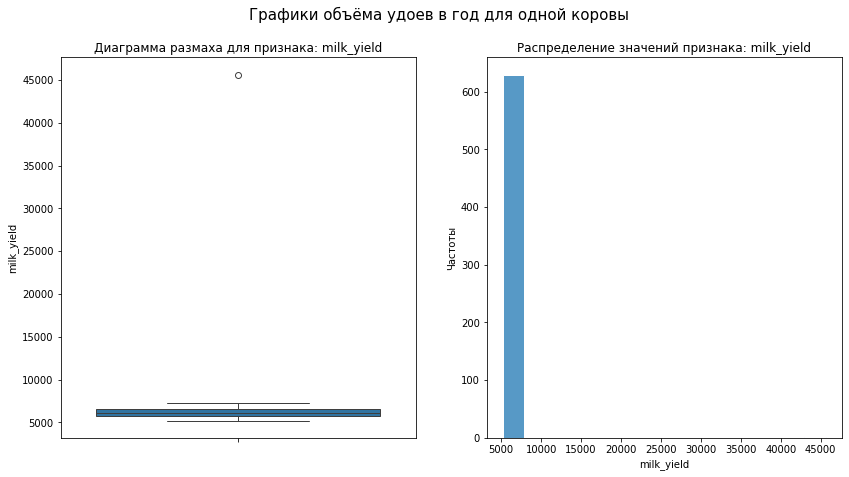

In [31]:
# построим графики для признака 'milk_yield'
num_feature_plots(data=data_ferma, feature='milk_yield', bins=15,
                  name = 'Графики объёма удоев в год для одной коровы')

In [32]:
# мы видим выбросы на графике, посмотрим, сколько в таблице строк с аномальным значением по удою
data_ferma.query('milk_yield > 10000')

,id,milk_yield,efu,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_%,protein_%,taste_milk,age
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


In [33]:
# удалим строку с аномальным значением по удою из двух датафреймов
data_ferma = data_ferma.loc[data_ferma['milk_yield'] < 10000].reset_index(drop=True)
ferma_dad = ferma_dad.query('id != 17').reset_index(drop=True)

# выведем описательные статистики по удою молока после удаления аномалии
print(data_ferma['milk_yield'].describe())

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: milk_yield, dtype: float64


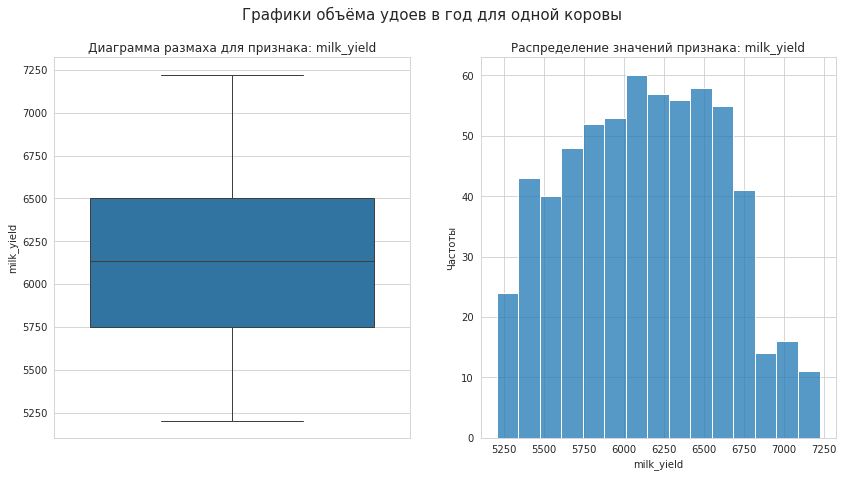

In [34]:
# построим графики для признака 'milk_yield'
num_feature_plots(data=data_ferma, feature='milk_yield', bins=15,
                  name = 'Графики объёма удоев в год для одной коровы')

In [35]:
# выведем описательные статистики по ЭКЕ
data_ferma['efu'].describe()

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: efu, dtype: float64

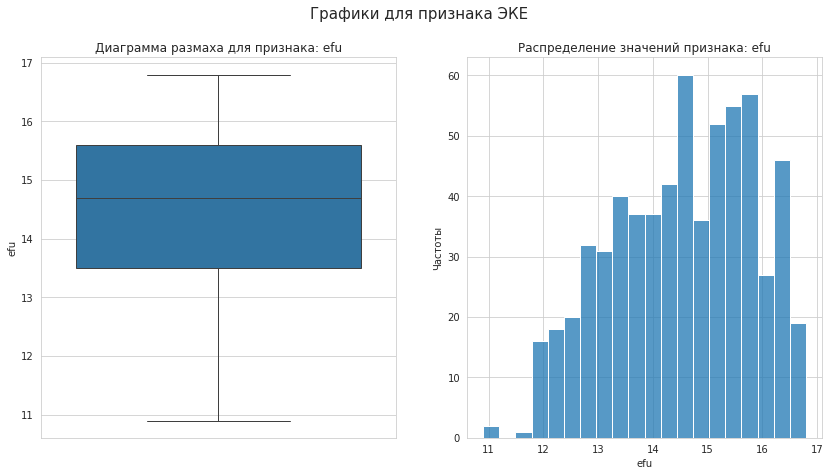

In [36]:
# построим графики для признака 'efu'
num_feature_plots(data=data_ferma, feature='efu', bins=20,
                  name = 'Графики для признака ЭКЕ')

In [37]:
# выведем описательные статистики по содержанию сырого протеина в корме
data_ferma['raw_protein'].describe()

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: raw_protein, dtype: float64

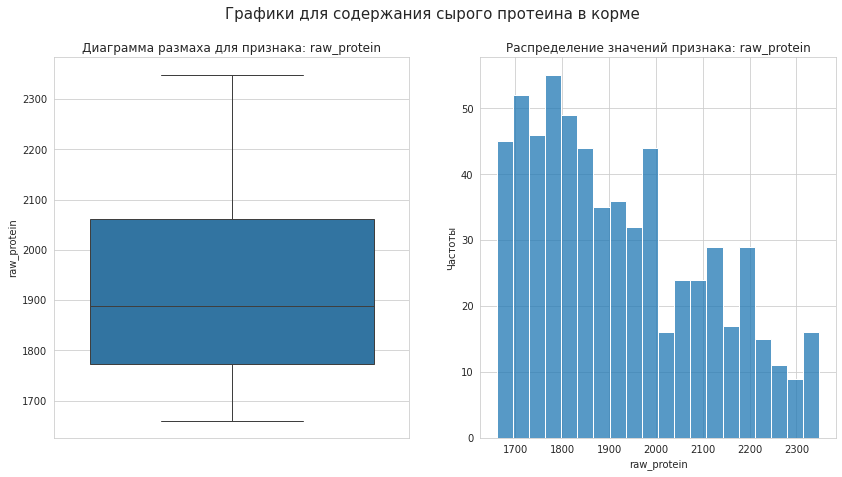

In [38]:
# построим графики для признака 'raw_protein'
num_feature_plots(data=data_ferma, feature='raw_protein', bins=20,
                  name = 'Графики для содержания сырого протеина в корме')

In [39]:
# выведем описательные статистики по сахаро-протеиновому соотношению
data_ferma['sugar_protein_ratio'].describe()

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: sugar_protein_ratio, dtype: float64

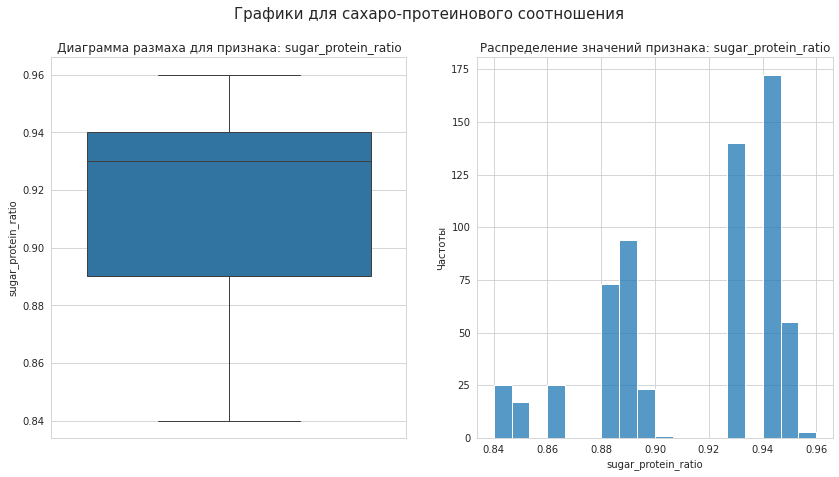

In [40]:
# построим графики для признака 'sugar_protein_ratio'
num_feature_plots(data=data_ferma, feature='sugar_protein_ratio', bins=18,
                  name = 'Графики для сахаро-протеинового соотношения')

In [41]:
# выведем описательные статистики по жирности молока
data_ferma['fat_%'].describe()

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fat_%, dtype: float64

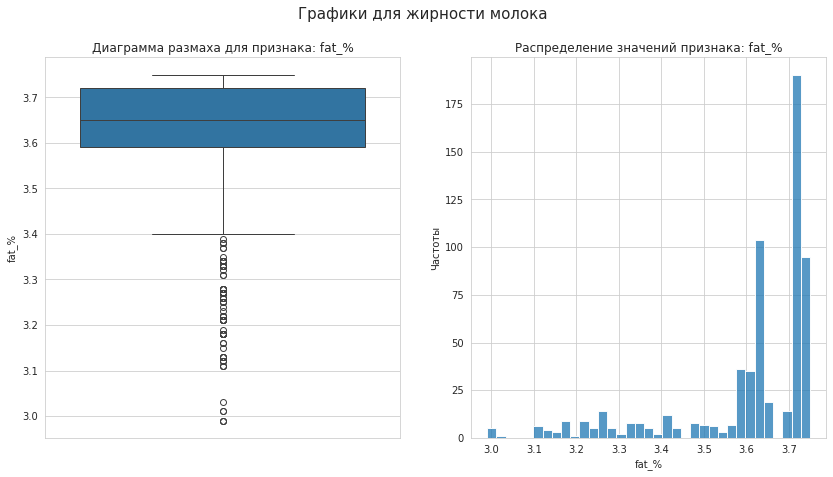

In [42]:
# построим графики для признака 'fat_%'
num_feature_plots(data=data_ferma, feature='fat_%', bins=35,
                  name = 'Графики для жирности молока')

In [43]:
# выведем описательные статистики по содержанию белков в молоке
data_ferma['protein_%'].describe()

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein_%, dtype: float64

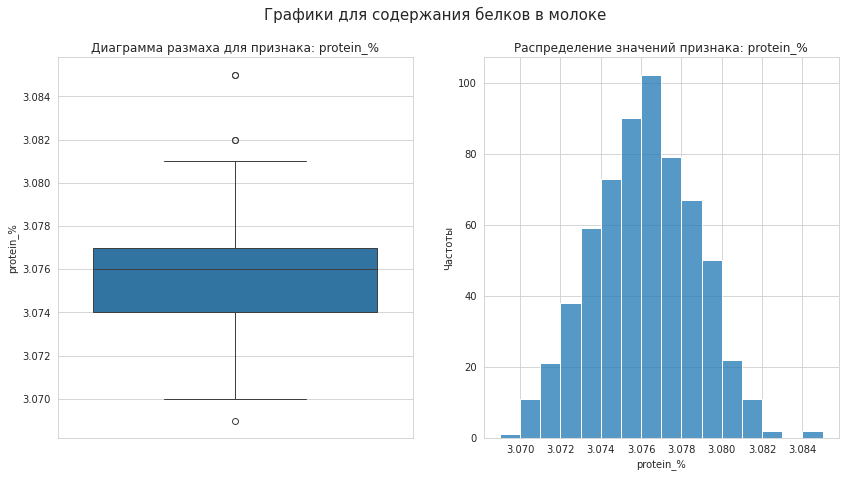

In [44]:
# построим графики для признака 'protein_%'
num_feature_plots(data=data_ferma, feature='protein_%', bins=16,
                  name = 'Графики для содержания белков в молоке')

In [45]:
# выведем статистику по породам коров
data_ferma['breed'].value_counts()

breed
Вис Бик Айдиал     372
РефлешнСоверинг    256
Name: count, dtype: int64

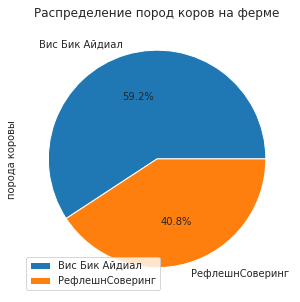

In [46]:
# построим круговую диаграмму, показывающую распределение пород коров
data_ferma['breed'].value_counts().plot(figsize = (7, 5), kind = 'pie',
                                        legend=True, ylabel = 'порода коровы',
                                        autopct = '%1.1f%%')
plt.title('Распределение пород коров на ферме')
plt.show()

In [47]:
data_ferma['pasture_type'].value_counts() # выведем статистику по типам пастбищ

pasture_type
холмистое    350
равнинное    278
Name: count, dtype: int64

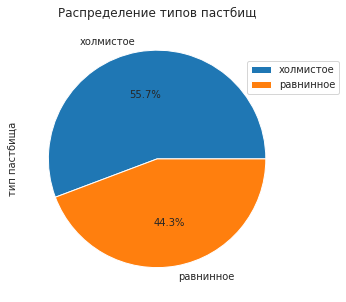

In [48]:
# построим круговую диаграмму, показывающую распределение типов пастбищ
data_ferma['pasture_type'].value_counts().plot(figsize = (7, 5), kind = 'pie',
                                               legend=True, ylabel = 'тип пастбища',
                                               autopct = '%1.1f%%')
plt.legend(bbox_to_anchor = (1, 0.8), loc = 'center')
plt.title('Распределение типов пастбищ')
plt.show()

In [49]:
# выведем статистику по породе папы коровы на ферме
data_ferma['dad_breed'].value_counts()

dad_breed
Айдиал     317
Соверин    311
Name: count, dtype: int64

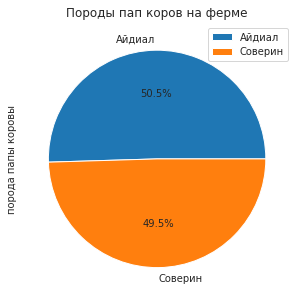

In [50]:
# построим круговую диаграмму, показывающую распределение пород пап коров
data_ferma['dad_breed'].value_counts().plot(figsize = (7, 5), kind = 'pie',
                                            legend=True, ylabel = 'порода папы коровы',
                                            autopct = '%1.1f%%')
plt.title('Породы пап коров на ферме')
plt.show()

In [51]:
# выведем статистику по вкусу молока
data_ferma['taste_milk'].value_counts()

taste_milk
вкусно       370
не вкусно    258
Name: count, dtype: int64

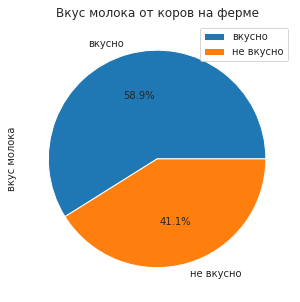

In [52]:
# построим круговую диаграмму, показывающую распределение вкуса молока
data_ferma['taste_milk'].value_counts().plot(figsize = (7, 5), kind = 'pie',
                                             legend=True, ylabel = 'вкус молока',
                                             autopct = '%1.1f%%')
plt.title('Вкус молока от коров на ферме')
plt.show()

In [53]:
# выведем статистику по возрасту коров
data_ferma['age'].value_counts()

age
более_2_лет    518
менее_2_лет    110
Name: count, dtype: int64

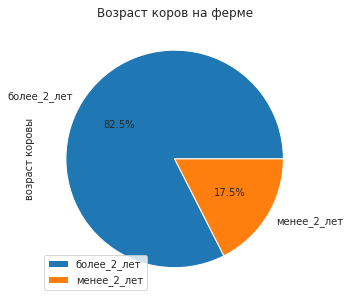

In [54]:
# построим круговую диаграмму, показывающую распределение возраста коров
data_ferma['age'].value_counts().plot(figsize = (7, 5), kind = 'pie',
                                      legend=True, ylabel = 'возраст коровы',
                                      autopct = '%1.1f%%')
plt.title('Возраст коров на ферме')
plt.show()

In [55]:
ferma_dad['dad_name'].value_counts() # выведем статистику по именам пап коров

dad_name
Барин       240
Буйный      214
Соловчик    110
Геркулес     64
Name: count, dtype: int64

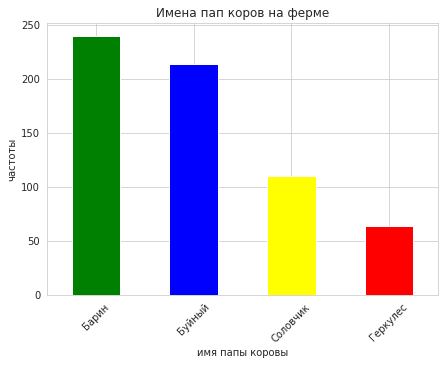

In [56]:
# построим столбчатую диаграмму по именам пап коров на ферме
ferma_dad['dad_name'].value_counts().plot(figsize = (7, 5), kind = 'bar',
                                          rot = 45, color = ['green', 'blue',
                                                             'yellow', 'red'],
                                          grid = True)
plt.title('Имена пап коров на ферме')
plt.xlabel('имя папы коровы')
plt.ylabel('частоты')
plt.show()

**Выводы:** 

Мы провели статистический анализ всех признаков, построили соответсвующие графики для описания каждого из признаков. Для количественных данных мы использовали гистраграммы и диаграммы размаха, а для категориальных данных круговые диаграммы и столбчатую диаграмму. 

В данных по удоям (`milk_yield`) было обнаружено одно анамальное значение (явно это ошибка данных), мы удалили его, после чего график по целевому признаку показал распределение близкое к нормальному. Распределение по ЭКЕ (`efu`) также близко к нормальному и не содержит выбросов, аномальных значений. Распределение содержания сырого протеина в корме (`raw_protein`) уже нельзя назвать нормальным, мы получаем ассиметричный график с гораздо меньшим диапазоном значений слева от среднего значения по сравнению с правой частью от среднего. Выбросов по сырому протеину не наблюдается. По сахаро-протеиновому соотношению (`sugar_protein_ratio`) мы видим, что график также не показал нормального распределения, можно условно выделить две группы зачений - более 0.91 и менее 0.91. Группа значение СПО более 0.91 более многочисленная, медианное значение для признака - 0.93. Для жирности (`fat_%`) мы наблюдаем 81 значение ниже 3.4, которые по графику диаграммы размаха идентифицируются как выбросы. Удалять эти значения не стоит, их слишком много, и очевидно они представляют реальные, а не ошибочные значения, таким образом, при удалении мы потеряем много важных для модели значений. По признаку содержания белков в молоке (`protein_%`) мы получили график нормального распределения, даже несмотря на то, что есть небольшое кол-во выбросов. В данном случае выбросами можно принебречь, они не так сильно расходятся с остальными значениями, и их сравнительно мало, чтобы оказать влияние на прогнозные значения. При построении прогнозных моделей стоит более внимательно относиться к признакам с распределением, отличным от нормального, возможно, от части из них стоит отказаться, а часть, вероятно, имеет смысл свести к категориальным признакам.

По каждому из категориальных признаков `taste_milk` (вкус молока), `breed` (порода), `dad_breed` (порода папы), `pasture_type` (тип пастбища), `age` (возраст коровы) есть всего 2 значения, а по признаку `dad_name` (имя папы) данные содержат 4 отличных значения. По признаку `dad_breed` кол-во двух разных значений практически одинаково (разница - 1%), тогда как по другим признакам значения распределены в разных пропорциях. Наибольшая разница наблюдается в значениях по возрасту, на ферме всего 17,5% коров возрастом менее 2-х лет, тогда как 82,5% коров имеет возраст старше 2-х лет. Также мы видим, что имя папы "Барин" боле чем в два раза встречается чаще чем имя "Соловчик" и почти в 4 раза чаще имени "Геркулес". Неравномерно распределение категориальных признаков следует иметь в виду при определении зависимостей между признаками.  

## Корреляционный анализ

1.	Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками. 

2.	Построим диаграммы рассеяния scatterplot для признака `Удой, кг` и всех количественных признаков с учётом значения категориальных признаков.

3.	Сделаем выводы о взаимосвязи признаков.


<Axes: >

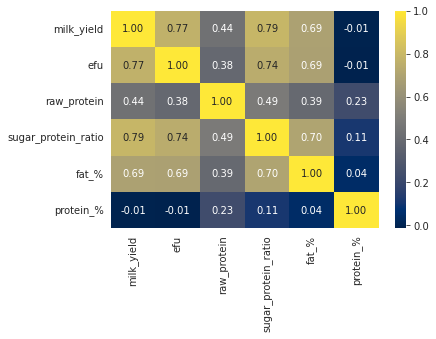

In [57]:
# построим таблицу коэффициентов корреляции между количественными признаками
sns.heatmap(data_ferma[['milk_yield', 'efu', 'raw_protein',
                        'sugar_protein_ratio', 'fat_%', 'protein_%'
                       ]].corr('spearman'), annot=True, fmt='.2f', cmap='cividis')

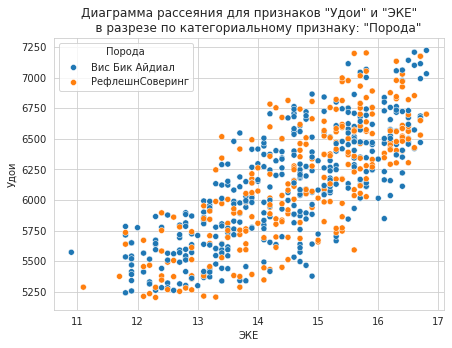

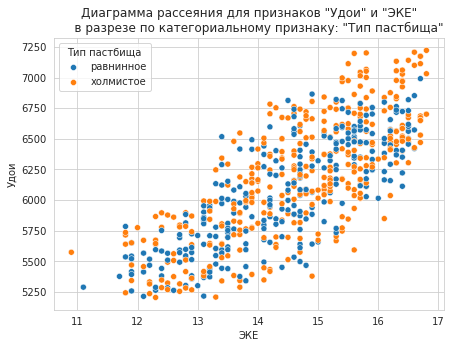

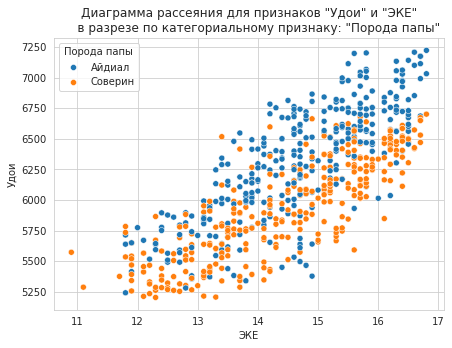

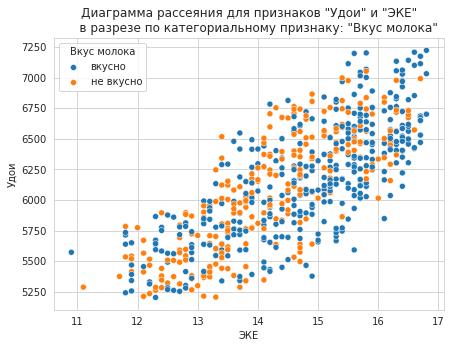

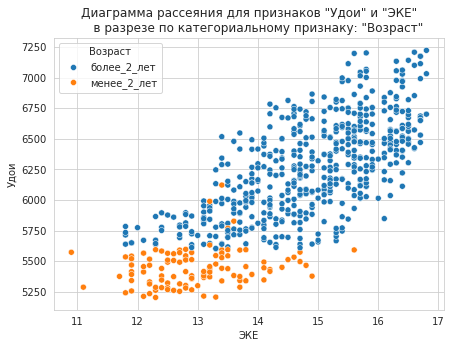

In [58]:
# создадим лист из категориальных признаков 
# построим диаграммы рассения для целевого признака 'milk_yield' и признака 'efu' в разрезе по категориальным признакам
category_group = ['breed', 'pasture_type', 'dad_breed', 'taste_milk', 'age']
category_name = ['Порода', 'Тип пастбища', 'Порода папы',
                 'Вкус молока', 'Возраст']

for i in range(len(category_group)):
    plt.figure(figsize = (7, 5))
    sns.scatterplot(data = data_ferma, x='efu', y = 'milk_yield',
                    hue = category_group[i])
    plt.title(f'Диаграмма рассеяния для признаков "Удои" и "ЭКЕ"\n \
    в разрезе по категориальному признаку: "{category_name[i]}"')
    plt.xlabel('ЭКЕ')
    plt.ylabel('Удои')
    plt.legend(title = category_name[i])
    plt.show()

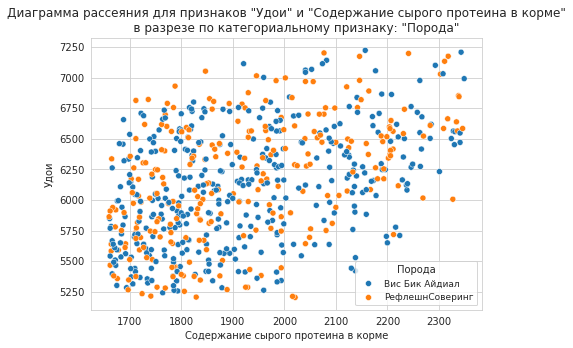

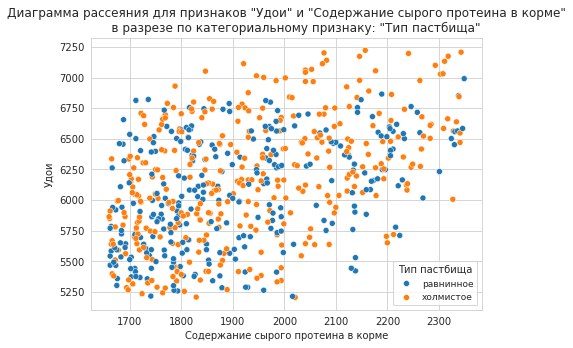

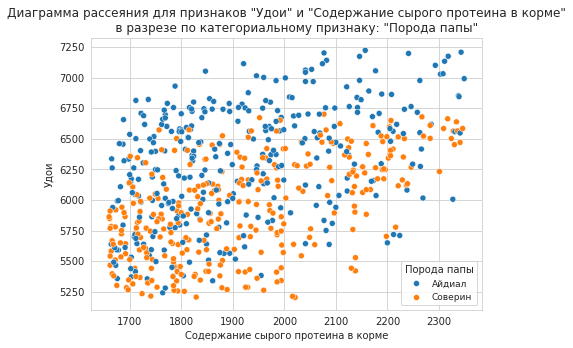

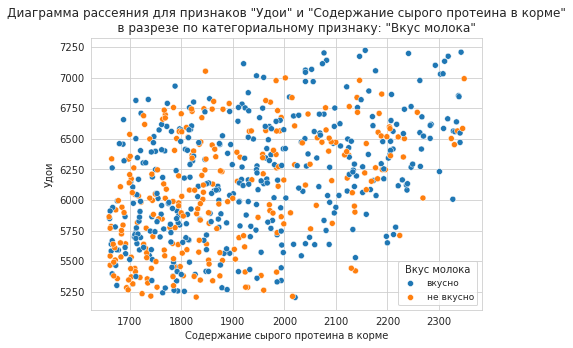

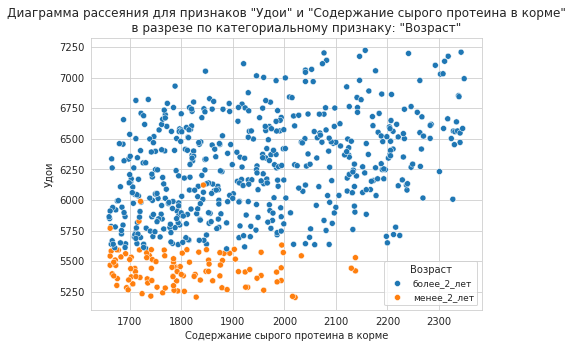

In [59]:
# построим диаграммы рассения для целевого признака 'milk_yield' и признака 'raw_protein' в разрезе по категориальным признакам
for i in range(len(category_group)):
    plt.figure(figsize = (7, 5))
    sns.scatterplot(data = data_ferma, x='raw_protein', y = 'milk_yield',
                    hue = category_group[i])
    plt.title(f'Диаграмма рассеяния для признаков "Удои" и "Содержание сырого протеина в корме"\n \
    в разрезе по категориальному признаку: "{category_name[i]}"')
    plt.xlabel('Содержание сырого протеина в корме')
    plt.ylabel('Удои')
    plt.legend(title = category_name[i], fontsize = '9', loc = 'lower right')
    plt.show()

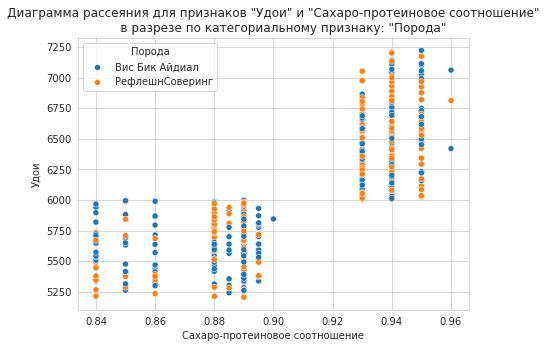

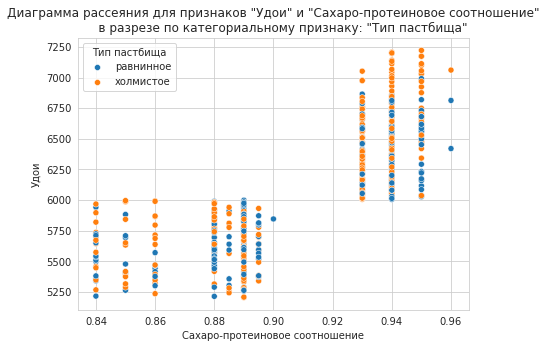

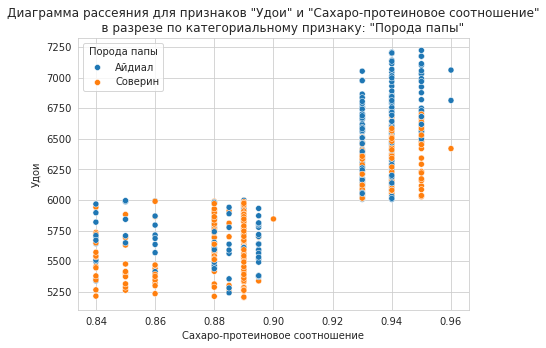

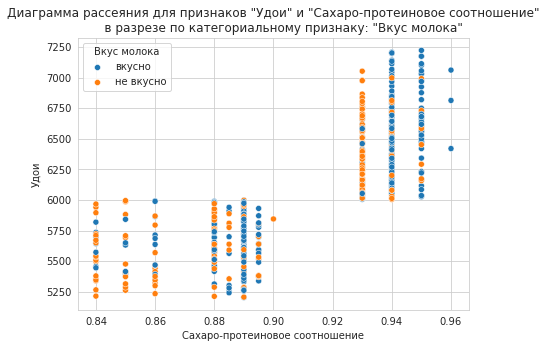

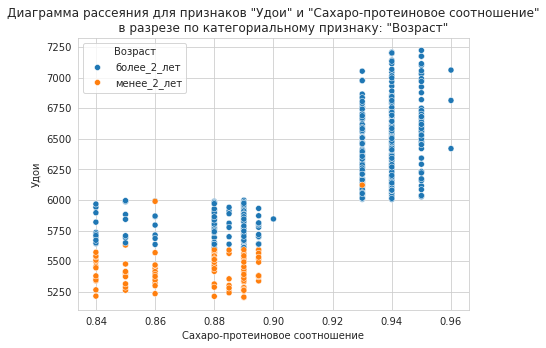

In [60]:
# построим диаграммы рассения для целевого признака 'milk_yield' и признака 'sugar_protein_ratio' в разрезе по категориальным признакам
for i in range(len(category_group)):
    plt.figure(figsize = (7, 5))
    sns.scatterplot(data = data_ferma, x='sugar_protein_ratio', y = 'milk_yield',
                    hue = category_group[i])
    plt.title(f'Диаграмма рассеяния для признаков "Удои" и "Сахаро-протеиновое соотношение"\n \
    в разрезе по категориальному признаку: "{category_name[i]}"')
    plt.xlabel('Сахаро-протеиновое соотношение')
    plt.ylabel('Удои')
    plt.legend(title = category_name[i])
    plt.show()

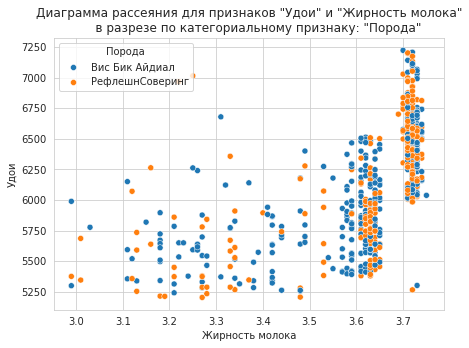

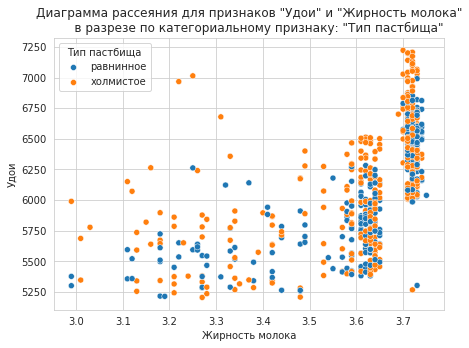

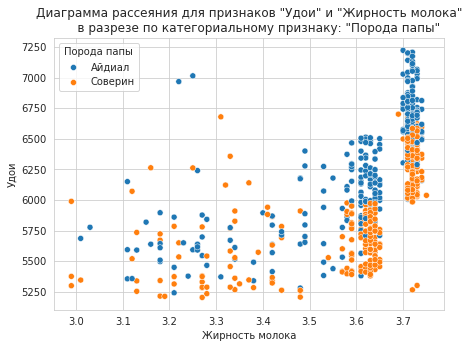

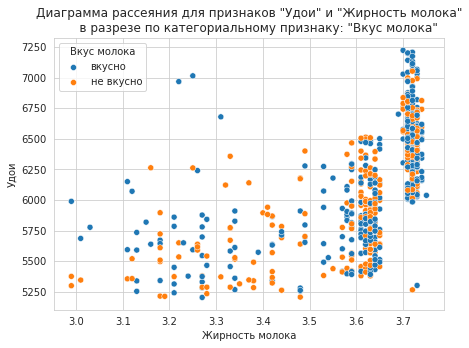

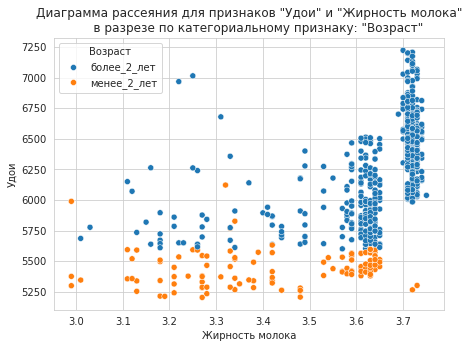

In [61]:
# построим диаграммы рассения для целевого признака 'milk_yield' и признака 'fat_%' в разрезе по категориальным признакам
for i in range(len(category_group)):
    plt.figure(figsize = (7, 5))
    sns.scatterplot(data = data_ferma, x='fat_%', y = 'milk_yield',
                    hue = category_group[i])
    plt.title(f'Диаграмма рассеяния для признаков "Удои" и "Жирность молока"\n \
    в разрезе по категориальному признаку: "{category_name[i]}"')
    plt.xlabel('Жирность молока')
    plt.ylabel('Удои')
    plt.legend(title = category_name[i])
    plt.show()

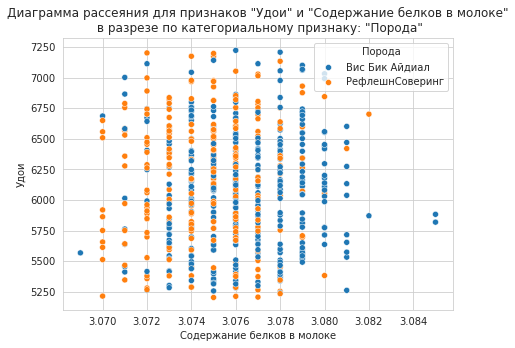

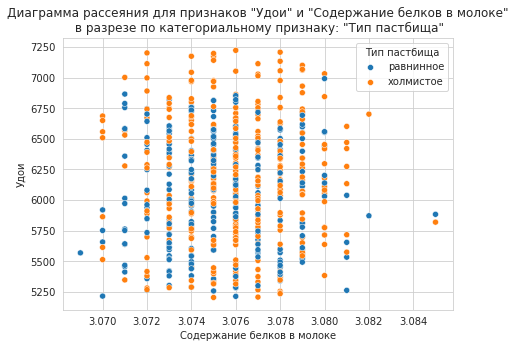

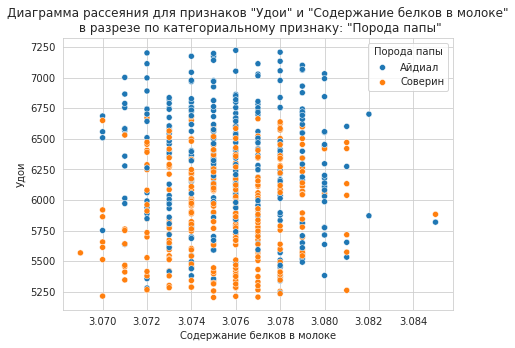

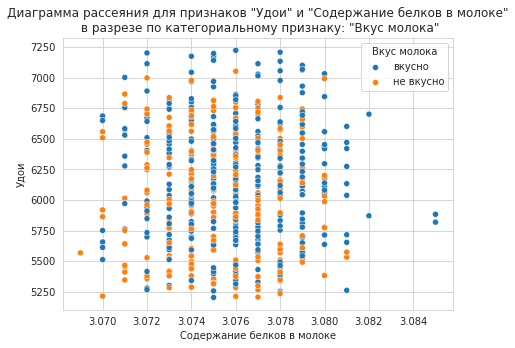

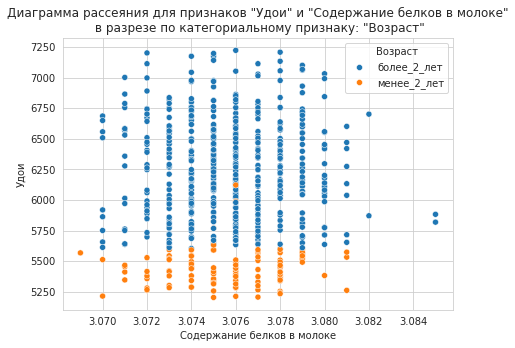

In [62]:
# построим диаграммы рассения для целевого признака 'milk_yield' и признака 'protein_%' в разрезе по категориальным признакам
for i in range(len(category_group)):
    plt.figure(figsize = (7, 5))
    sns.scatterplot(data = data_ferma, x='protein_%', y = 'milk_yield', hue = category_group[i])
    plt.title(f'Диаграмма рассеяния для признаков "Удои" и "Содержание белков в молоке"\n в разрезе по категориальному признаку: "{category_name[i]}"')
    plt.xlabel('Содержание белков в молоке')
    plt.ylabel('Удои')
    plt.legend(title = category_name[i])
    plt.show()

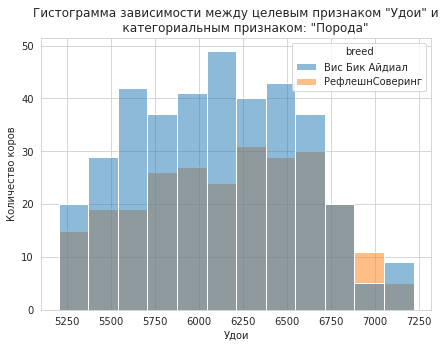

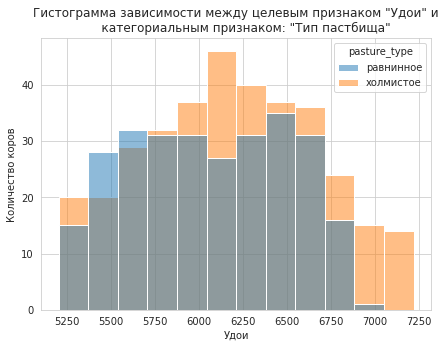

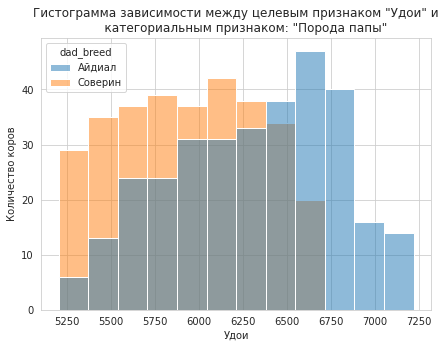

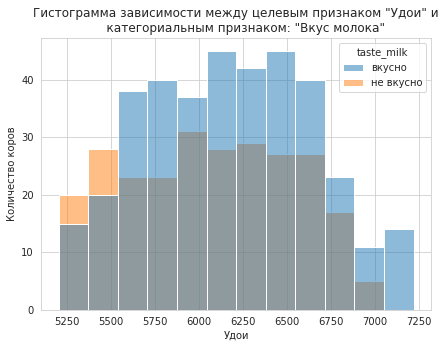

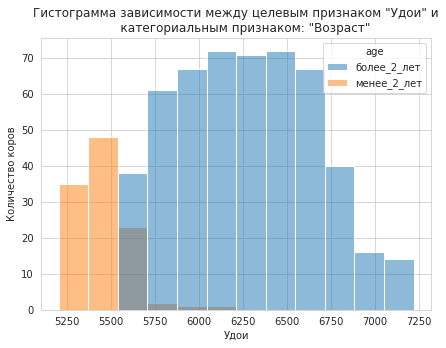

In [63]:
# построим гистограммы зависимости для целевого признака 'milk_yield' и категориальными признаками
for i in range(len(category_group)):
    plt.figure(figsize = (7, 5))
    sns.histplot(data = data_ferma, x = 'milk_yield', hue = category_group[i])
    plt.title(f'Гистограмма зависимости между целевым признаком "Удои" и\n \
    категориальным признаком: "{category_name[i]}"')
    plt.xlabel('Удои')
    plt.ylabel('Количество коров')
    plt.show()


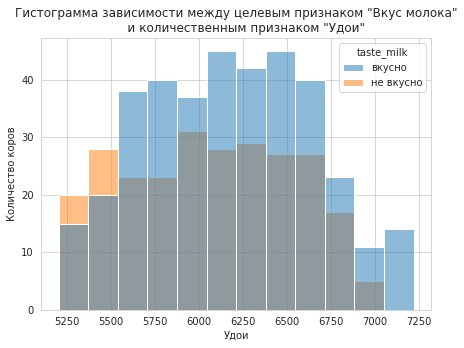

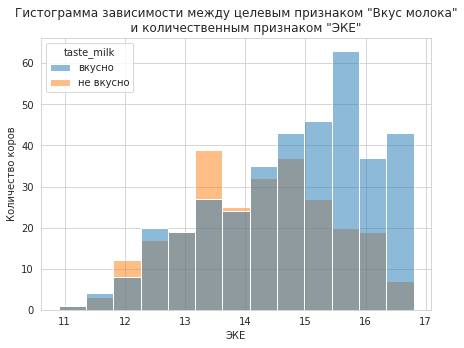

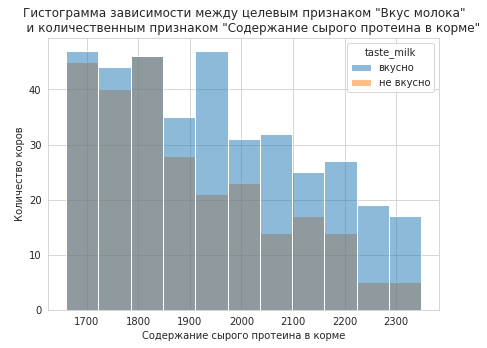

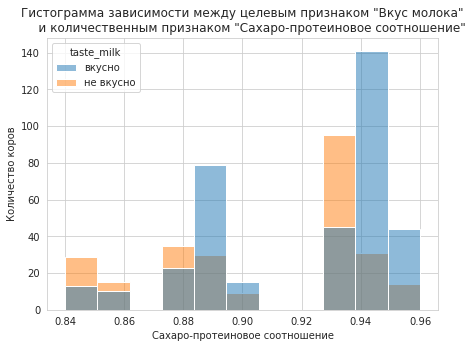

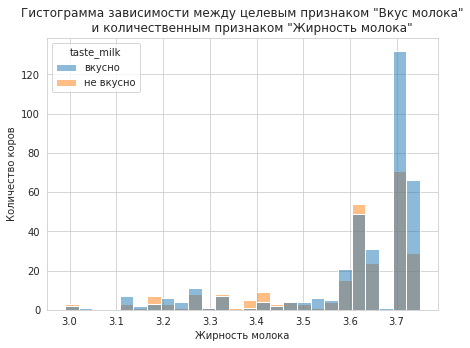

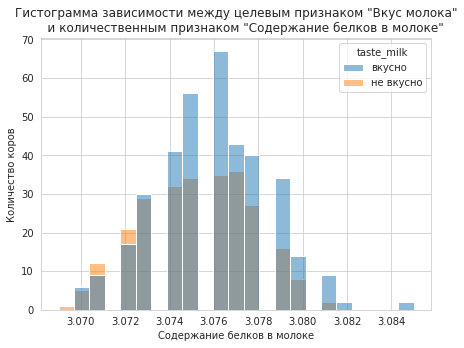

In [64]:
# зададим лист из количественных признаков 
# построим гистограммы зависимости для категориального целевого признака 'taste_milk' и количественных признаков
quan_group =['milk_yield', 'efu', 'raw_protein', 'sugar_protein_ratio',
             'fat_%', 'protein_%']
quan_name = ['Удои', 'ЭКЕ', 'Содержание сырого протеина в корме',
             'Сахаро-протеиновое соотношение', 'Жирность молока',
             'Содержание белков в молоке']

for i in range(len(quan_group)):
    plt.figure(figsize = (7, 5))
    sns.histplot(data = data_ferma, x = quan_group[i], hue = 'taste_milk')
    plt.title(f'Гистограмма зависимости между целевым признаком "Вкус молока"\n \
    и количественным признаком "{quan_name[i]}"')
    plt.xlabel(quan_name[i])
    plt.ylabel('Количество коров')
    plt.show()

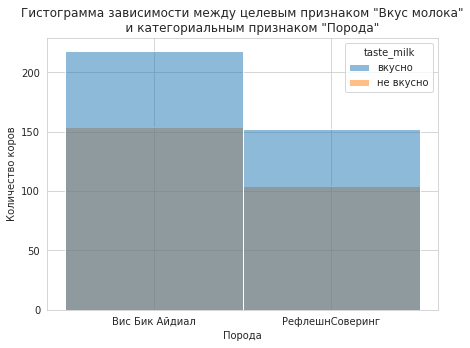

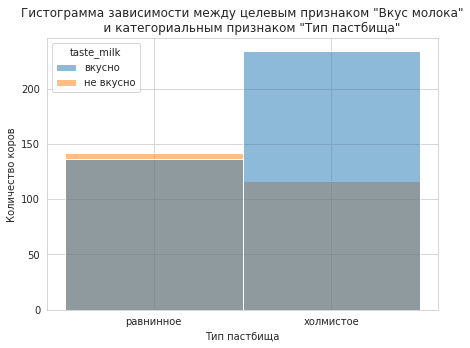

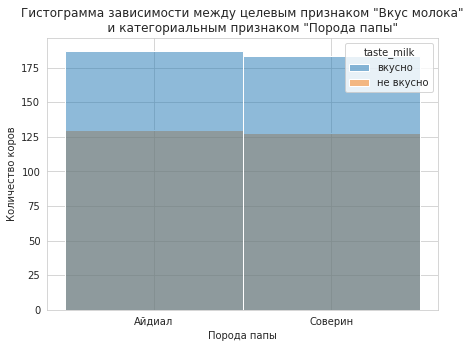

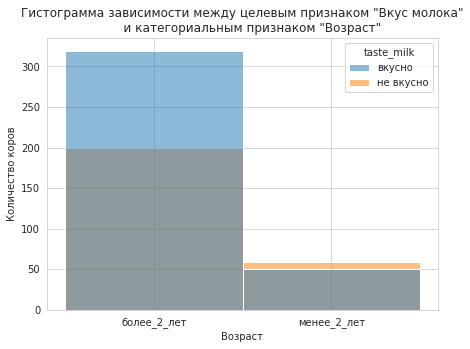

In [65]:
# зададим лист из категориальных признаков
# построим гистограммы зависимости для целевого признака 'taste_milk' и категориальных признаков
cat_group = ['breed', 'pasture_type', 'dad_breed', 'age']
cat_name = ['Порода', 'Тип пастбища', 'Порода папы', 'Возраст']

for i in range(len(cat_group)):
    plt.figure(figsize = (7, 5))
    sns.histplot(data = data_ferma, x = cat_group[i], hue = 'taste_milk')
    plt.title(f'Гистограмма зависимости между целевым признаком "Вкус молока"\n \
    и категориальным признаком "{cat_name[i]}"')
    plt.xlabel(cat_name[i])
    plt.ylabel('Количество коров')
    plt.show()

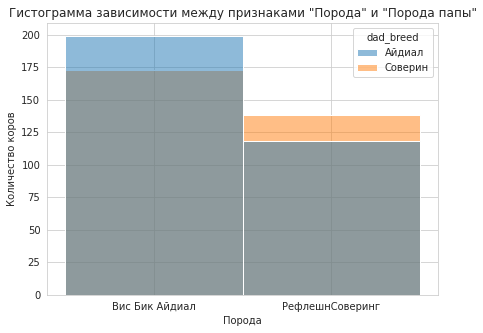

In [66]:
# построим гистограмму зависимости между признаками 'breed' и 'dad_breed'
plt.figure(figsize = (7, 5))
sns.histplot(data = data_ferma, x = 'breed', hue = 'dad_breed')
plt.title('Гистограмма зависимости между признаками "Порода" и "Порода папы"')
plt.xlabel('Порода')
plt.ylabel('Количество коров')
plt.show()

**Выводы:**

Между количесвтенными признаками (включая целевой количественный признак) были определены коэффициенты корреляции Спирмена. Мы использовали коэффициент Спирмена, т.к. для 3-х из 6-ти признаков распределение не является нормальным. Между целевым признаком `milk_yield` (удои) и признаками `efu` (ЭКЕ) и `sugar_protein_ratio` (сахаро-протеиновое соотношение) наблюдается высокая прямая корреляционная связь (коэффициенты 0.77 и 0.79), т.е. при увеличении значений этих признаков растёт и значение целевого признака. Между целевым признаком `milk_yield` и признаком `fat_%` (жирность молока) наблюдается заметная прямая корреляционная связь (коэффициент 0.69). Признак `raw_protein` (содержание сырого протеина) имеет умеренную прямую корреляционную связь с целевым признаком (коэффициент 0.44). А признак `protein_%` (содержание белков в молоке) не имеет корреляционной связи с целевым признаком `milk_yield` (коэффициент -0.01). Между количественными признаками `sugar_protein_ratio` и `efu`, а также `sugar_protein_ratio` и `fat_%` наблюдается сильная корреляционная связь (коэффициенты 0.70 и 0.74). Однако значения коэффициентов корреляции между указанными признаками меньше 0.9, поэтому между ними не наблюдается мультиколлениарности, и их олновременно можно использовать для построения модели линейной регрессии. 

Зависимость между признаками `milk_yield` и `raw_protein` близка к линейной, при том что корреляция между признаками умеренная. Между признаками `milk_yield` и `efu` прослеживается зависимость, близкая, но отличная от линейной. Между другими количественными признаками и целевым признаком не прослеживается линейной связи. В случаях, когда связь между целевым и входным признаком нелинейная следует с помощью дополнительных преобразований входных признаков исключить нелинейность, чтобы входные признаки были информативны для линейной регрессии.

Среди категориальных признаков наиболее сильную связь с объемов удоев (`milk_yield`) мы видим у признака `age` (возраст), по графикам диаграммы размаха чётко видно деление точек на два кластера. Коровы с возрастом менее 2-х лет не дают таких высоких удоев как коровы старше 2-х лет, какими бы не были другие количественные показатели. Также некоторая более слабая связь прослеживается между `milk_yield` и категориальными признаками `pasture_type` (тип пастибща) и `dad_breed`. На высоких показателях удоев заметно, что холмистый тип пастибща встречается чаще равнинного, и что порода папы "Айдиал" встречается гораздо чаще породы "Соверин". Практически не наблюдается никакой связи между категориальными признаками `breed` (порода) и `milk_taste` (вкус молока) и целевым признаком `milk_yield`.

По графикам мы наблюдаем, что целевой категориальный признак `milk_taste` имеет некоторую связь с количественными признаками `efu_new`, `protein_%`, `sugar_protein_ratio`, `fat_%`. Высоким значениям указанных признаков соответвует заметно больше коров с вкусным молоком, тогда как при низких показателях мы видим преобладание коров с невкусным молоком. Также вкус молока связан с такими категориальными признаками как тип пастбища (`pasture_type`) и возраст (`age`). Вкусное молоко чаще соответствует коровам старше 2 лет и холмистым пастбищам.

## Обучение модели линейной регрессии

In [67]:
# отбираем признаки для первой модели линейной регрессии
X = data_ferma.drop(['milk_yield', 'id', 'protein_%', 'taste_milk', 'breed'], axis=1) 
y = data_ferma['milk_yield']

# разобъем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = RANDOM_STATE)

cat_col_names = ['pasture_type', 'dad_breed', 'age']
num_col_names = ['efu', 'raw_protein', 'sugar_protein_ratio', 'fat_%']

In [68]:
# задаем преобразование данных в ColumnTransformer
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_col_names),
        ('ohe', OneHotEncoder(drop='first', sparse_output=True), cat_col_names)
    ],
         remainder='passthrough'
)

# создаем пайплайн для регрессии
final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

final_pipe.fit(X_train, y_train)
predictions_1 = final_pipe.predict(X_test)

In [69]:
# oценим качество модели на тестовой выборке
r2 = r2_score(y_test, predictions_1)
round(r2, 3)

0.784

In [70]:
# вычислим остатки между истинными значениями и предсказанными моделью
residuals = y_test - predictions_1
print('Среднее значение остатков', residuals.mean())

Среднее значение остатков -23.162947647518635


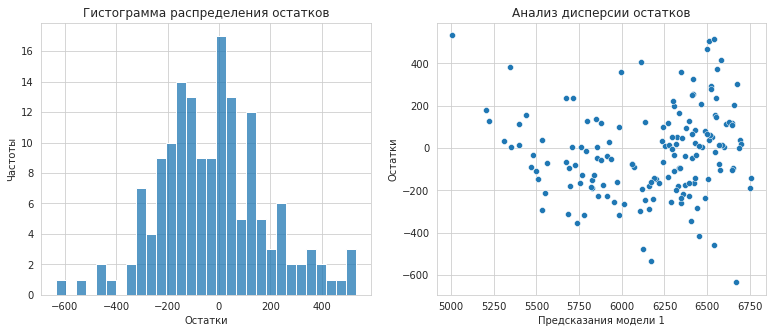

In [71]:
# построим гистограмму распределения остаков и диаграмму рассеяния для предсказаний удоя
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
sns.histplot(ax=axes[0], data=residuals, bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частоты')

sns.scatterplot(ax=axes[1], x = predictions_1, y = residuals)
axes[1].set_title('Анализ дисперсии остатков')
axes[1].set_xlabel('Предсказания модели 1')
axes[1].set_ylabel('Остатки')
plt.show()

**Выводы по первой модели линейной регрессии:**
Для первой модели простой линейной регресии мы прежде всего отобрали признаки, необходимые для построения модели, которая позволяет прогнозировать целевой признак - `удои`. Из количественных признаков мы выбрали `ЭКЕ`, `содержание сырого протеина в корме`, `сахаро-протеиновое соотношение` и `жирность молока`. Мы не использовали количественный признак `содержание белков в молоке`, поскольку коэффициент корреляции Спирмена между этим признаком и целевым признаком составляет всего -0.01. Из категориальных мы выбрали признаки `тип пастбища`, `порода папы`, `возраст`. Мы не включили в модель категориальные признаки `id`, `порода`, `вкус молока`. Идентификационный номер уникален для каждой коровы, и таким образом никак не может быть связан с целевым признаком. Вкус молока является целевым признаком для следующего этапа исследования и как показывают графики (рассеяния и гистограммы) зависит от части других признаков (количественных и категориальных), но не имеет заметной связи с целевым признаком `удои`. Порода коровы, как показали графики, не имеет сильной корреляции с удоями, но явно коррелирует с породой папы коровы. В свою очередь порода папы имеет более сильную корреляцию с целевым признаком по сравнению с породой коровы, что хорошо видно по диаграмме рассеяния и по гистограмме. Поэтому мы оставили для модели только породу папы.

Коэффициент детерминации R² для первой получившейся модели равен 0.784

Мы построили гистограмму распределения остатков и график рассеяния для визуализации дисперсии остатков. Гистограмма остатков показывает распределение, близкое к нормальному. Однако среднее значение остатков смещено влево (значение -23.2). Это означает, что модель больше склонна давать завышенные (выше истинных) прогнозные значения. Дисперсия остатков показывает незначительные колебания. Заметно, что при прогнозных значениях удоев свыше 6100, дисперсия остатков начинает увеличиваться. Поскольку у остатков нарушается свойство постоянства дисперсии, то модель в работе использовать нежелательно, её нужно улучшить, для чего мы проведем дополнительные исследования.


Подготовим данные с учётом связи входных признаков с целевым и обучим на них вторую модель LinearRegression

In [72]:
# создадим и затем применим функцию для категоризации значений СПО
def spr_category(spr):
    if spr < 0.91:
        return 0
    elif spr >= 0.91:
        return 1

data_ferma['sugar_protein_ratio_bin'] = data_ferma['sugar_protein_ratio'].apply(spr_category)

# для устранения нелинейности добавим новый признак - ЭКЕ, возведенное в квадрат
data_ferma['efu_new'] = data_ferma['efu']**2

In [73]:
data_ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       628 non-null    int64  
 1   milk_yield               628 non-null    int64  
 2   efu                      628 non-null    float64
 3   raw_protein              628 non-null    int64  
 4   sugar_protein_ratio      628 non-null    float64
 5   breed                    628 non-null    object 
 6   pasture_type             628 non-null    object 
 7   dad_breed                628 non-null    object 
 8   fat_%                    628 non-null    float64
 9   protein_%                628 non-null    float64
 10  taste_milk               628 non-null    object 
 11  age                      628 non-null    object 
 12  sugar_protein_ratio_bin  628 non-null    int64  
 13  efu_new                  628 non-null    float64
dtypes: float64(5), int64(4), o

In [74]:
# отбираем признаки для второй модели линейной регрессии
X = data_ferma.drop(['milk_yield', 'id', 'protein_%', 'taste_milk',
                     'breed', 'sugar_protein_ratio', 'efu'], axis=1) 
y = data_ferma['milk_yield']

# разобъем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

cat_col_names = ['pasture_type', 'dad_breed', 'age', 'sugar_protein_ratio_bin']
num_col_names = ['efu_new', 'raw_protein', 'fat_%']

In [75]:
# задаем преобразование данных в ColumnTransformer
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_col_names),
        ('ohe', OneHotEncoder(drop='first', sparse_output=True), cat_col_names)
    ],
         remainder='passthrough'
)

# создаем пайплайн для регрессии
final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

final_pipe.fit(X_train, y_train)
predictions_2 = final_pipe.predict(X_test)

In [76]:
# oценим качество модели на тестовой выборке
r2 = r2_score(y_test, predictions_2)
round(r2, 3)

0.817

In [77]:
# вычислим остатки между истинными значениями и предсказанными моделью
residuals_2 = y_test - predictions_2
print('Среднее значение остатков', residuals_2.mean())

Среднее значение остатков -21.71035881585971


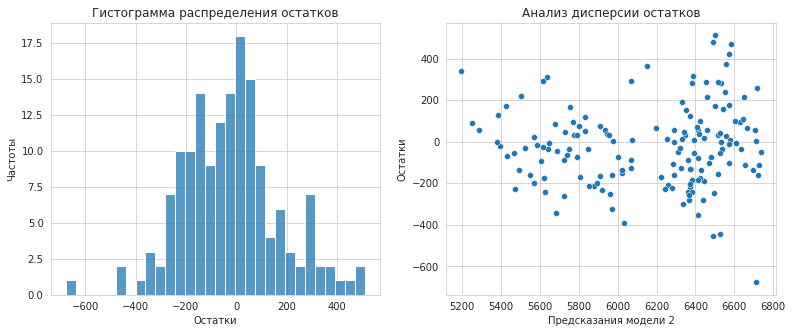

In [78]:
# построим гистограмму распределения остаков и диаграмму рассеяния по значениям остатков и показателю удоя
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
sns.histplot(ax=axes[0], data=residuals_2, bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частоты')

sns.scatterplot(ax=axes[1], x = predictions_2, y = residuals_2)
axes[1].set_title('Анализ дисперсии остатков')
axes[1].set_xlabel('Предсказания модели 2')
axes[1].set_ylabel('Остатки')
plt.show()

**Выводы по второй модели линейной регрессии:**
Для второй модели простой линейной регресии по сравнению с первой мы постарались учесть характер зависимости признаков с целевым признаком. Для тех случаев, где прослеживается нелинейная связь, мы выполнили преобразования признаков. Так мы обнаружили, что СПО и Удой связаны нелинейно. На диаграмме рассеяния наблюдения сгруппированы в два кластера, поэтому мы преобразовали СПО в категориальный бинарный признак, выбрав значение, по которому проходит граница между двумя группами. Для построения модели мы использовали этот преобразованный признак. Кроме того мы заметили, что ЭКЕ и Удой связаны нелинейно. Нелинейность между ними можно исключить, введя новый признак ЭКЕ в квадрате, именно такой новый признак мы использовали для построения модели. Остальные признаки, использованные в первой модели, мы оставили без изменений. Количественне признаки:  преобразованное `ЭКЕ`, `содержание сырого протеина в корме` и `жирность молока`. Категориальные признаки: `тип пастбища`, `порода папы`, `возраст`, `сахаро-протеиновое соотношение`, преобразованное в бинарный признак. Затем мы повторили все те же шаги, что делали для построения первой модели.

Коэффициент детерминации R² для второй получившейся модели равен 0.817, что на 0.033 больше чем для первой модели и соответственно ближе к 1. Это значит, что предсказания модели точнее по сравнению с первой моделью.

Мы построили гистограмму распределения остатков и график рассеяния для визуализации дисперсии остатков. Гистограмма остатков показывает распределение, близкое к нормальному. Среднее значение остатков как и в случае первой модели смещено влево (значение -21.7), правда это значение уменьшилось в абсолютном выражении. Смещение влево означает, что модель больше склонна давать завышенные (выше истинных) прогнозные значения. Кроме того, мы наблюдаем на гистограмме один явный выброс со значением ниже -600. Дисперсия остатков показывает незначительные колебания. По-прежнему как и в случае первой модели при высоких значениях удовев дисперсия увеличивается. Однака граница, после которой наблюдается увеличение, сместилась от 6100 к 6400. Поскольку у остатков нарушается свойство постоянства дисперсии, то модель в работе использовать нежелательно, её нужно улучшить, для чего будут проведены дополнительные исследования.

Теперь добавим в данные новый признак и обучим на них третью модель LinearRegression 

In [79]:
# добавим новый признак 'dad_name' из датафрейма 'ferma_dad'
data_ferma = data_ferma.merge(ferma_dad, on = 'id')
data_ferma.head()

,id,milk_yield,efu,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_%,protein_%,taste_milk,age,sugar_protein_ratio_bin,efu_new,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,Барин


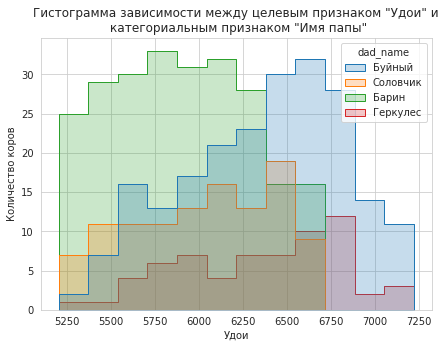

In [80]:
# посмотрим взаимосвязь между значениями целевого показателя 'удои' и именами папы 
plt.figure(figsize = (7, 5))
sns.histplot(data = data_ferma, x = 'milk_yield', hue = 'dad_name', element = 'step')
plt.title('Гистограмма зависимости между целевым признаком "Удои" и\n \
категориальным признаком "Имя папы"')
plt.xlabel('Удои')
plt.ylabel('Количество коров')
plt.show()

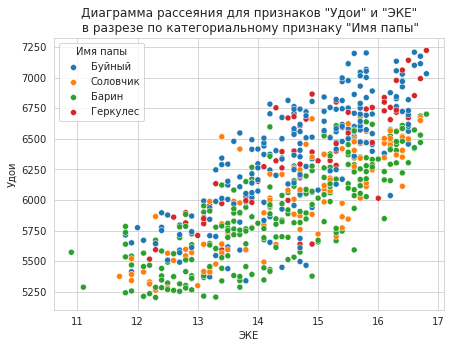

In [81]:
# посмотрим взаимосвязь между значениями целевого показателя 'удои' и  'эке' в разрезе по категории 'имя папы' 
plt.figure(figsize = (7, 5))
sns.scatterplot(data = data_ferma, x='efu', y = 'milk_yield', hue = 'dad_name')
plt.title('Диаграмма рассеяния для признаков "Удои" и "ЭКЕ"\n в разрезе по категориальному признаку "Имя папы"')
plt.xlabel('ЭКЕ')
plt.ylabel('Удои')
plt.legend(title = 'Имя папы')
plt.show()

In [82]:
data_ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       628 non-null    int64  
 1   milk_yield               628 non-null    int64  
 2   efu                      628 non-null    float64
 3   raw_protein              628 non-null    int64  
 4   sugar_protein_ratio      628 non-null    float64
 5   breed                    628 non-null    object 
 6   pasture_type             628 non-null    object 
 7   dad_breed                628 non-null    object 
 8   fat_%                    628 non-null    float64
 9   protein_%                628 non-null    float64
 10  taste_milk               628 non-null    object 
 11  age                      628 non-null    object 
 12  sugar_protein_ratio_bin  628 non-null    int64  
 13  efu_new                  628 non-null    float64
 14  dad_name                 6

In [83]:
# отбираем признаки для третьей модели линейной регрессии
X = data_ferma.drop(['milk_yield', 'id', 'protein_%', 'taste_milk',
                     'breed', 'sugar_protein_ratio', 'efu'], axis=1)
y = data_ferma['milk_yield']

# разобъем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = RANDOM_STATE)

cat_col_names = ['pasture_type', 'dad_breed', 'age',
                 'sugar_protein_ratio_bin', 'dad_name']
num_col_names = ['efu_new', 'raw_protein', 'fat_%']

In [84]:
# задаем преобразование данных в ColumnTransformer
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_col_names),
        ('ohe', OneHotEncoder(drop='first', sparse_output=True), cat_col_names)
    ],
         remainder='passthrough'
)

# создаем пайплайн для регрессии
final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

final_pipe.fit(X_train, y_train)
predictions_3 = final_pipe.predict(X_test)

In [85]:
# oценим качество модели на тестовой выборке
r2 = r2_score(y_test, predictions_3)
round(r2, 3)

0.821

In [86]:
# вычислим остатки между истинными значениями и предсказанными моделью
residuals_3 = y_test - predictions_3
print('Среднее значение остатков', residuals_3.mean())

Среднее значение остатков -12.113575058012927


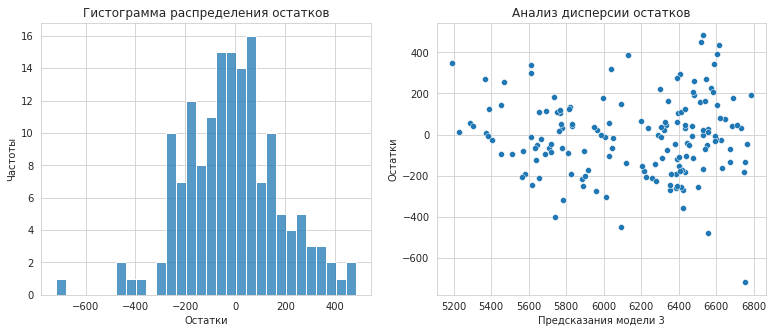

In [87]:
# построим гистограмму распределения остаков и диаграмму рассеяния по значениям остатков и показателю удоя
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
sns.histplot(ax=axes[0], data=residuals_3, bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Частоты')

sns.scatterplot(ax=axes[1], x = predictions_3, y = residuals_3)
axes[1].set_title('Анализ дисперсии остатков')
axes[1].set_xlabel('Предсказания модели 3')
axes[1].set_ylabel('Остатки')
plt.show()

**Выводы по третьей модели линейной регрессии:**
Для третьей модели простой линейной регресии по сравнению со второй мы ввели один дополнительный категориальный признак `имя папы`, который подтянули из второго датафрейма с именами пап коров по ключу - значению `id`. Таким образом для модели мы взяли следующие  количественне признаки: `ЭКЕ` в квадрате, `содержание сырого протеина в корме` и `жирность молока`. А в качестве категориальных признаков отобрали: `тип пастбища`, `порода папы`, `возраст`, `сахаро-протеиновое соотношение`, преобразованное в бинарный признак, и `имя папы`. Затем мы повторили все те же шаги, что делали для построения первой и второй модели.

Коэффициент детерминации R² для третьей получившейся модели равен 0.821, что на 0.004 больше чем для второй модели и на 0.037 больше R² для первой модели. Таким образом ошибка R² ближе к 1, по сравнению с первыми двумя моделями. Это значит, что предсказания модели точнее по сравнению с рассмотренными ранее моделями.

Мы построили гистограмму распределения остатков и диаграмму рассеяния для визуализации дисперсии остатков. Гистограмма остатков показывает распределение, близкое к нормальному. Среднее значение остатков как и в случае двух первых моделей смещено влево (значение -12.1), однако значение примерно в два раза уменьшилось в абсолютном выражении. Смещение влево означает, что модель больше склонна давать завышенные (выше истинных) прогнозные значения. Кроме того, мы также как и во второй модели наблюдаем на гистограмме один явный выброс со значением ниже -600. Дисперсия остатков для третьей модели не имеет заметных колебаний, можно считать, что свойство постоянство дисперсии остатков не нарушено. Однако на диаграмме рассения также заметен один явный выброс при высоком значении целевого показателя. Такую модель можно использовать для дальнейшей работы, но в то же время очевидно, что её можно ещё улучшить.

Теперь сравним качество трёх моделей линейной регрессии, сопоставив их R² и остатки

**Выводы по R² и остаткам 3-х рассмотренных моделей:**
Мы наблюдаем поэтапное улучшение показателей при рассмотрении трёх разных моделей линейной регрессии. R² для первой модели 0.784, для второй 0.816, для третьей 0.821. Таким образом, ошибка R² в третьей моделе стала ближе к 1, по сравнению с первыми двумя моделями, т.е. предсказания модели точнее по сравнению с рассмотренными ранее моделями. По гистограммам распределения остатков мы видим, что график для третьей модели стал ближе к нормальному, смещение влево стало заметно меньше, т.е. разница между истинными значениями целевого показателя и предсказанными значениями стала ближе к 0. Однако, при этом модель даёт один явный выброс, и это значит что модель ещё можно улучшить. В отличие от первых двух моделей мы видим, что на третьей моделе наконец наблюдается постоянство дисперсии остатков, что означает, что модель работает лучше первых двух. Можно сделать вывод, что устранение нелинейности между признаками и добавление нового признака `имя папы` способствовало улучшению прогнозной модели.


Посчитаем для каждой модели 3 метрики: MSE, MAE, RMSE.

In [88]:
# рассчитаем метрики качества для первой модели
mse_1 = mean_squared_error(y_test, predictions_1)
rmse_1 = root_mean_squared_error(y_test, predictions_1)
mae_1 = mean_absolute_error(y_test, predictions_1)

# рассчитаем метрики качества для второй модели
mse_2 = mean_squared_error(y_test, predictions_2)
rmse_2 = root_mean_squared_error(y_test, predictions_2)
mae_2 = mean_absolute_error(y_test, predictions_2)

# рассчитаем метрики качества для третьей модели
mse_3 = mean_squared_error(y_test, predictions_3)
rmse_3 = root_mean_squared_error(y_test, predictions_3)
mae_3 = mean_absolute_error(y_test, predictions_3)

# выведем метрики качества по всем трём моделям
print(f'Метрики качества первой модели:\n среднеквадратичная ошибка (mse): {mse_1:.2f}\n \
корень среднеквадратичной ошибки (rmse): {rmse_1:.2f}\n \
средняя абсолютная ошибка (mae): {mae_1:.2f}\n')
print(f'Метрики качества второй модели:\n среднеквадратичная ошибка (mse): {mse_2:.2f}\n \
корень среднеквадратичной ошибки (rmse): {rmse_2:.2f}\n \
средняя абсолютная ошибка (mae): {mae_2:.2f}\n')
print(f'Метрики качества третьей модели:\n среднеквадратичная ошибка (mse): {mse_3:.2f}\n \
корень среднеквадратичной ошибки (rmse): {rmse_3:.2f}\n \
средняя абсолютная ошибка (mae): {mae_3:.2f}\n')

Метрики качества первой модели:
 среднеквадратичная ошибка (mse): 43929.68
 корень среднеквадратичной ошибки (rmse): 209.59
 средняя абсолютная ошибка (mae): 163.62

Метрики качества второй модели:
 среднеквадратичная ошибка (mse): 37344.85
 корень среднеквадратичной ошибки (rmse): 193.25
 средняя абсолютная ошибка (mae): 148.38

Метрики качества третьей модели:
 среднеквадратичная ошибка (mse): 36508.01
 корень среднеквадратичной ошибки (rmse): 191.07
 средняя абсолютная ошибка (mae): 147.27



**Вывод:** Мы видим, что по всем трём метрикам оценки качества модели лучшей является третья модель. Для третьей модели каждай из трёх метрик (mse, rmse, mae) наименьшая по сравнению с первой и второй моделями.

In [89]:
# посчитаем доверительный интервал прогноза лучшей модели. 
dif_value = abs(y_test - predictions_3)
quantile = dif_value.quantile(q=0.5)
print('Значение доверительного интервала для лучшей модели (номер 3):',
      round(quantile, 2))

Значение доверительного интервала для лучшей модели (номер 3): 120.32


С помощью лучшей модели спрогнозируем удой коров, которых фермер хочет купить

In [90]:
# добавим в датафрейм по коровам для покупки расчётные значения ЭКЕ, сырого протеина в корме и СПО
cow_buy['efu'] = data_ferma['efu'].mean()*1.05
cow_buy['raw_protein'] = data_ferma['raw_protein'].mean()*1.05
cow_buy['sugar_protein_ratio'] = data_ferma['sugar_protein_ratio'].mean()*1.05

# добавим столбец со значениями ЭКЕ в квадрате
cow_buy['efu_new'] = cow_buy['efu']**2

In [91]:
# приведем в соотвествие столбцы в датафреймах, выведем первые строки датафрейма 'cow_buy'
cow_buy['sugar_protein_ratio_bin'] = cow_buy['sugar_protein_ratio'
                                            ].apply(spr_category)
cow_buy.head()

,breed,pasture_type,dad_breed,dad_name,fat_%,protein_%,age,efu,raw_protein,sugar_protein_ratio,efu_new,sugar_protein_ratio_bin
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,1
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,1


In [92]:
# задаём выборку для прогноза
X_pred = cow_buy.drop(['protein_%', 'breed', 'sugar_protein_ratio', 
                       'efu'], axis=1)

# построим прогноз по удою коров, которых хочет купить фермер
y_pred_final = final_pipe.predict(X_pred)
print('Прогноз удоев коров, которых хочет купить фермер:\n\n',
      np.around(y_pred_final, 2))

Прогноз удоев коров, которых хочет купить фермер:

 [6595.53 6362.19 6248.43 6530.28 6522.03 6408.7  6595.53 6546.26 6248.43
 6352.45 6355.57 6607.35 6616.36 6093.42 6248.43 6530.28 6355.57 6437.85
 6498.37 6522.03]


**Выводы:**

После того как мы получили оптимальную модель линейной регресии для пронозирования удоев молока, мы применили обученную модель к новой выборке из 20 коров, которых хочет купить фермер. Прежде чем сделать прогноз удоев молока для новой выборки, мы привели датафрейм с 20 коровами, предложенными фермеру, в соответствие с датафреймом, по которому проводили обучение модели. Мы добавили все недостающие столбцы в датафрейм. Значения признаков ЭКЕ, Сырой протеин и СПО мы посчитали как средние значения соответсвующих признаков из датафрейма по коровам на ферме, увеличенные на 5%. После добавления новых столбцов мы убедились, что столбцы в обоих датафреймах имеют одинаковые названия. Затем мы кодировали категориальные признаки по 20 коровам с помощью метода One-Hot-Encoding и в результате получили новые столбцы. После этого мы масштабировали количественные признаки методом стандартизации (StandardScaler). И в завершение мы создали датафреймы из категориальных и количественных признаков после их преобразований и объединили эти два датафрейма в один, который использовали для получения прогнозных значений по удоям. В результате прогноза мы получили, что по всем 20 коровам прогнозные значения превышают 6000.

## Обучение модели логистической регрессии

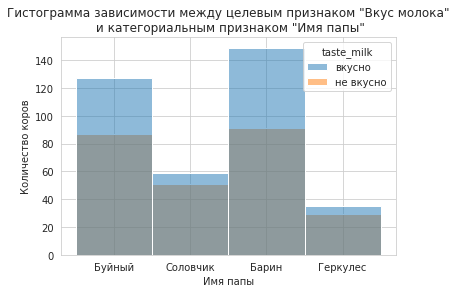

In [93]:
# посмотрим на гистограмме связь имени папы со вкусом молока
plt.figure(figsize = (6, 4))
sns.histplot(data = data_ferma, x = 'dad_name', hue = 'taste_milk')
plt.title('Гистограмма зависимости между целевым признаком "Вкус молока"\n и категориальным признаком "Имя папы"')
plt.xlabel('Имя папы')
plt.ylabel('Количество коров')
plt.show()

In [94]:
# создадим и затем применим функцию для категоризации вкуса молока как бинарного признака со значениями 1 и 0
def taste_milk_category(taste):
    if taste == 'вкусно':
        return 1
    elif taste == 'не вкусно':
        return 0

data_ferma['taste_milk_bin'] = data_ferma['taste_milk'].apply(taste_milk_category)

In [95]:
# задаем выборку для прогноза
X = data_ferma.drop(['milk_yield', 'id', 'raw_protein', 'taste_milk', 'taste_milk_bin',
                     'breed', 'efu_new', 'dad_breed'], axis=1)
y = data_ferma['taste_milk_bin']

# разобъем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

cat_col_names = ['pasture_type', 'age', 'dad_name', 'sugar_protein_ratio_bin']
num_col_names = ['efu', 'protein_%', 'fat_%', 'sugar_protein_ratio']

In [96]:
# задаем преобразование данных в ColumnTransformer
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_col_names),
        ('ohe', OneHotEncoder(drop='first', sparse_output=True), cat_col_names)
    ],
         remainder='passthrough'
)

# создаем пайплайн для логистической регрессии
final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression())
    ]
)

final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

In [97]:
# оценим качество модели на тестовой выборке метриками accuracy, recall, precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Значение метрики accuracy (доля точных ответов): {accuracy:.3f}\n\
Значение метрики recall (полнота): {recall:.3f}\n\
Значение метрики precision (точность): {precision:.3f}')

Значение метрики accuracy (доля точных ответов): 0.643
Значение метрики recall (полнота): 0.886
Значение метрики precision (точность): 0.629


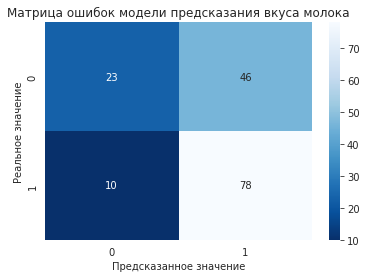

In [98]:
# построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues_r')
plt.title('Матрица ошибок модели предсказания вкуса молока')
plt.ylabel('Реальное значение')
plt.xlabel('Предсказанное значение')
plt.show()

В нашей задаче при покупке коров наиболее критичная ошибкой является ошибка первого рода или иными словами ложноположительная ошибка (`False Positive`). В таком случае для верного решения задачи нам важно минимизировать возможность неправильно выбрать коров со вкусным молоком, т.е. отобрать для покупки таких коров, молоко которых на самом деле будет невкусным. При этом для нас не так критично, если часть коров со вкусным молоком будут определены прогнозной моделью как коровы с невкусным молоком. Если соотнести наш вывод с метриками, то выходит, что нам нужно выбрать для построения прогнноза метрику `precision`. Нам нужно подобрать такое пороговое значение принадлежности к классам, при котором число ошибок типа `False Positive` будет равно нулю, и тогда в свою очередь метрика `precision` будет равна 1.

In [99]:
# создаем таблицу со столбцом предсказаний вероятности, значение в котором сравнивается с порогом вероятности, заданном  модели
y_proba = final_pipe.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba),
                    columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',
                                                                  ascending=False)

data.head()

,y_valid,y_proba
4,1,0.834987
17,1,0.833864
114,1,0.829035
64,1,0.827331
136,1,0.816545


In [100]:
# задаем 100 пороговых значений на отрезке от 0.1 до 1
# для каждого порогового значение считаем precision, recall, True Positive, False Positive
thresholds = np.around(np.linspace(0.01, 1, 100, endpoint=False), 2)

columns = []
precision_thr = []
recall_thr = []
true_positive = []
false_positive = []
cm_thr = []

for i in thresholds:
    columns.append(str(i))
    data['y_pred_'] = data['y_proba'].apply(lambda x: 1 if x>= i else 0)
    precision = round(precision_score(data['y_valid'], data['y_pred_'],
                                      zero_division=0), 3)
    precision_thr.append(precision)
    recall = round(recall_score(data['y_valid'], data['y_pred_']), 3)
    recall_thr.append(recall)
    data['tp'] = data.apply(lambda x: 1 if (x['y_valid']== 1) &
                            (x['y_pred_']==1) else 0, axis = 1)
    data['fp'] = data.apply(lambda x: 1 if (x['y_valid']== 0) &
                            (x['y_pred_']==1) else 0, axis = 1)    
    true_positive.append(data['tp'].sum())
    false_positive.append(data['fp'].sum())
    cm = confusion_matrix(data['y_valid'], data['y_pred_'])
    cm_thr.append(cm)

# создаем датафрейм со значениями порога, precision, recall, True Positive, False Positive
# подберем пороговое значение при котором значение False Positive равно 0
thresholds_select = pd.DataFrame(zip(columns, precision_thr, recall_thr,
                                     true_positive, false_positive),
                                 columns = ['Порог', 'precision', 'recall',
                                            'True Positive', 'False Positive'])
thresholds_select.tail(30)

,Порог,precision,recall,True Positive,False Positive
70,0.7,0.811,0.489,43,10
71,0.71,0.841,0.420,37,7
72,0.72,0.854,0.398,35,6
73,0.73,0.868,0.375,33,5
74,0.74,0.912,0.352,31,3
75,0.75,0.933,0.318,28,2
76,0.76,0.958,0.261,23,1
77,0.77,1.000,0.216,19,0
78,0.78,1.000,0.193,17,0
79,0.79,1.000,0.170,15,0


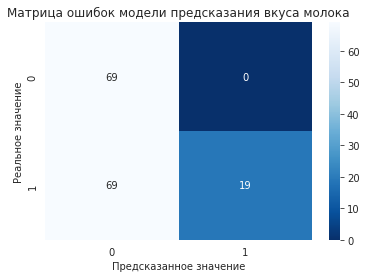

In [101]:
# посмотрим матрицу ошибок, посчитаннаую ранее, для указанного порогового значения
sns.heatmap(cm_thr[77], annot=True, cmap='Blues_r')
plt.title('Матрица ошибок модели предсказания вкуса молока')
plt.ylabel('Реальное значение')
plt.xlabel('Предсказанное значение')
plt.show()

**Выводы**:

Значения метрик для выбранной модели логистической регрегрсии при значении порога по умолчанию 0.5: 

precision - 0.629

recall - 0.886

Мы определили по построенной таблице с пороговыми значениями, что при значении порога 0.77 количество ошибок первого рода (False Positive) равно нулю, а при пороге 0.76 кол-во ошибок равно 1. В таблице отображены значения при пошаговом увеличении порога от 0.1 до 0.99. Поэтому следует выбрать 0.77 в качестве значения порога принадлежности к классам, при котором критическая ошибка равна нулю.   

Значения метрик для выбранной модели логистической регрегрсии при выборе значения порога 0.77:

precision - 1.0

recall - 0.216

При выбранном пороговом значении на тестовой выборке к классу один было отнесено 19 объектов (в нашем случае коров) из всего 88 объектов класса 1 в тестовой выборке. 

Далее с помощью обученной выборки, применив оптимальное пороговое значения определения класса 1 (вкусное молоко), мы сделаем прогноз вкуса молока для коров, предложенных к покупке для фермы.


С помощью обученной модели спрогнозируем вкус молока коров, которых фермер хочет купить. 

In [102]:
# добавляем категориальные бинарные признаки в датасет по коровам для покупки
X_pred = cow_buy.drop(['breed', 'dad_breed', 'raw_protein', 'efu_new'], axis=1)

# обучим модель логистической регрессии на подготовленных данных
y_proba = final_pipe.predict_proba(X_pred)[:,1]
y_proba_taste = (y_proba >= 0.77).astype(int)

print('Прогноз вкусности молока коров, которых фермер хочет купить, где 1 - вкусно, 0 - не вкусно:\n\n',
      y_proba_taste)

Прогноз вкусности молока коров, которых фермер хочет купить, где 1 - вкусно, 0 - не вкусно:

 [1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0]


**Выводы:**

После того как мы получили оптимальную модель логистической регресии для пронозирования вкуса молока, мы применили обученную модель к новой выборке из 20 коров, которых хочет купить фермер. Ещё на этапе построения прогноза по удоям мы добавили в датафрейм с 20 коровами все необходимые столбцы и убедились, что в столбце есть те же столбцы, что и в датафрейме для обучения модели. Поэтому мы сразу перешли к кодированию категориальных признаков по 20 коровам с помощью метода One-Hot-Encoding и в результате получили новые столбцы. После этого мы масштабировали количественные признаки методом стандартизации (StandardScaler). В завершение мы создали датафреймы из категориальных и количественных признаков после их преобразований и объединили их в один датафрейм, который использовали для получения прогнозных значений вкуса молока. В результате прогноза мы получили, что при выбранном на предыдущем этапе оптимальном (для минимизации ошибок) пороговом значении вероятности 0.77 модель отбирает 7 из 20 коров как коров с вкусным молоком.

## Итоговые выводы

In [103]:
# добавим прогнозы вкуса молока и удоя коров в датафрейм с коровами, покупку которых рассматривает фермер
# добавим вероятность того, что у коровы вкусное молоко
cow_buy_predicted = cow_buy.drop(columns = ['efu_new', 'sugar_protein_ratio_bin'])
predict = pd.DataFrame(zip(y_pred_final, y_proba_taste, y_proba),
                    columns = ['milk_yield_predict', 'taste_milk_predict',
                               'probability_tasty_milk'])

cow_buy_predicted = np.around(cow_buy_predicted.merge(predict, left_index=True,
                                                      right_index=True), 2)
# выведем таблицу с прогнозными значениями и вероятностью того, что молоко у коровы вкусное
cow_buy_predicted

,breed,pasture_type,dad_breed,dad_name,fat_%,protein_%,age,efu,raw_protein,sugar_protein_ratio,milk_yield_predict,taste_milk_predict,probability_tasty_milk
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.28,2019.95,0.96,6595.53,1,0.86
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет,15.28,2019.95,0.96,6362.19,1,0.81
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.28,2019.95,0.96,6248.43,0,0.74
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет,15.28,2019.95,0.96,6530.28,0,0.64
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет,15.28,2019.95,0.96,6522.03,0,0.72
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.05,менее_2_лет,15.28,2019.95,0.96,6408.70,0,0.24
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.28,2019.95,0.96,6595.53,1,0.86
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.08,более_2_лет,15.28,2019.95,0.96,6546.26,1,0.81
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.28,2019.95,0.96,6248.43,0,0.74
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.08,менее_2_лет,15.28,2019.95,0.96,6352.45,1,0.88


Результатом проделанной работы является выбор оптимальной модели линейной регрессии, которая позволяет сделать прогноз удоев молока для списка коров, предложенных для покупки фермеру, а также выбор оптимальной модели логистической регрессии, которая делает отбор коров с вкусным молоком из предложенного списка. Мы вывели таблицу по всем коровам, которые предлагаются для покупки фермеру, и добавили для каждой коровы прогнозные значения удоя молока (столбец `milk_yield_predict`), проноз вкусности молока (столбец `taste_milk_predict`), в котором 1 означает вкусное молоко, и вероятность того, что молоко будет вкусным (столбец `probability_tasty_milk`). Указанные три добавленных столбца демонстируют работу двух прогнозных моделей, подобранных в ходе работы. Мы видим, что все 20 коров имеют удой свыше 6000 кг в год, т.е. удовлетворяют запросу фермера. В результате прогноза вкуса молока модель отбирает всего 7 коров из 20 с вкусным молоком. Такой результат прогноза по вкусу молока связан с тем, что мы подобрали такой порог определения классов, при котором метрика ошибки `precision` равна 1, т.е. максимальная из возможных, а значение ошибки `False Positive` сведено к минимуму, т.е. равно 0 по нашей пронозной моделе. Таким образом, получается, что фермер может купить только 7 коров из 20 коров  с минимальным риском для себя. В то же время он может принимать решение по своему усмотрению. Если для фермера показатель вкуса молока также важен как и удои коровы, и если он хочет выбрать более 7 отобранных моделью коров, то мы рекомендуем ему принимать решение на основе показателя вероятности вкуса молока.

При подборе оптимальной модели линейной регресии мы постарались учесть характер зависимости входных признаков с целевым признаком. Для тех случаев, где прослеживается нелинейная связь, мы выполнили преобразования признаков. Так, мы обнаружили, что `СПО` и `Удои` связаны нелинейно, поэтому мы преобразовали `СПО` в категориальный бинарный признак, выбрав значение, по которому проходит граница между двумя группами, и использовали для модели новый преобразованный признак. Также мы заметили, что `ЭКЕ` и `Удои` связаны нелинейно. Нелинейность между этими признаками мы исключили, введя новый признак ЭКЕ в квадрате, который в дальнейшем использовали для построения модели. На следующем этапе улучшения модели линейной регрессии мы ввели один дополнительный категориальный признак `имя папы`. В результате проделанных шагов мы последовательно улучшили все метрики ошибок, а значение коэффициента детерминации стало всё ближе к 1. Коэффициент детерминации R² для оптимальной модели линейной регрессии равен 0.821. Значение среднеквадратичной ошибки (mse) для выбранной модели прогноза удоев молока — 36508.01, корень среднеквадратичной ошибки (rmse) — 191.07, средняя абсолютная ошибка (mae) — 147.27. 

Гистограмма остатков для модели линейной регресии показала распределение, близкое к нормальному. Однако среднее значение остатков немного смещено влево (значение -12.1). Смещение влево означает, что модель склонна давать завышенные (выше истинных) прогнозные значения. Кроме того, мы наблюдаем на гистограмме остатков один явный выброс со значением ниже -600. Свойство постоянство дисперсии остатков для выбранной оптимальной модели не было  нарушено. Получившаяся модель линейной регресии подходит для пронозирования удоев молока, однако результаты модели ещё можно улучшить, так чтобы среднее значение остатков было ближе к нулю. Для улучшения модели, вероятно, можно каким-то убразом устранить нелинейную зависимость удоев от жирности молока, однако сложно найти оптимальный способ, как это можно сделать. И ещё, вероятно, можно найти лучший способ устранить нелинейную зависимость между СПО и удоями молока.

Модель выбранной оптимальной логистической регрессии даёт недостаточно хорошие значения метрик ошибок: accuracy — 0.643 и precision — 0.629 при пороговом значении принадлежности к классам равным 0.5. Метрика recall  равна 0.886 при пороге 0.5. Однако, в нашей задаче нам нужно свести к минимуму неверный выбор коровы с хорошим молоком, т.е. более критической ошибкой будет определить вкус молока коровы вкусным, когда на самом деле он невкусный. С другой стороны у нас нет задачи определить максимальное число коров с вкусным молоком. Получается, что мы ориентируемся на ошибку первого рода и соответственно используем для решения задачи метрику precision, тогда как метрика recall нас не интересует. Мы бы выбрали метрику recall, если бы нужно было наиболее полно отобрать всех коров с вкусным молоком. Мы определили, что оптимальным для нашей модели будет значение порога принадлежности к классу 0.77, при котором количество ошибок первого рода (False Positive) сведено к нулю. При пороге 0.77 мы получили значение метрики precision — 1, а значение метрики recall — 0.216. Вкус молока очень сложно прогнозировать, поскольку связан с субъективной оценкой фермера, и недостаточно сильно связан с конкретными количественными или категориальными показателями. Вероятно, для улучшения точности нашей модели для прогноза вкуса молока нам не хватает каких-то дополнительных показателей, которые могут оказывать влияние на вкус молока.
